In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:

configs.data_name = data_name



In [7]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [8]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [9]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [10]:
data_name

'dd_fix_stats_demo'

In [11]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [12]:


data_name



'dd_fix_stats_demo'

In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,8,645.693750,283.247212,537.731250,5.683393,147.500000,78.438086,1,4,10,23,102.0
1,1,10,5,8,644.781081,202.020928,524.345946,8.486152,180.810811,88.588574,1,4,10,23,102.0
2,1,10,6,9,708.334615,292.435973,536.546154,7.099140,187.961538,130.054290,1,4,10,23,102.0
3,1,10,7,8,676.047619,317.074279,535.933333,6.465627,179.761905,73.502996,1,4,10,23,102.0
4,1,10,8,8,440.215000,235.935556,541.580000,5.290667,201.800000,91.100638,1,4,10,23,102.0


In [14]:
df_data_to_use.shape

(9071, 15)

In [15]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [16]:

x_org.head()



,FIX_X_std,FIX_DURATION_mean,Grade_2,FIX_Y_std,Grade_4,FIX_Y_mean,Grade_3,FIX_X_mean,Age,Grade_6,IQ,Sex_2,Grade_5,Word_Number,Sex_1,Grade_1,FIX_DURATION_std
0,283.247212,147.500000,0,5.683393,1,537.731250,0,645.693750,10,0,23,0,0,8,1,0,78.438086
1,202.020928,180.810811,0,8.486152,1,524.345946,0,644.781081,10,0,23,0,0,8,1,0,88.588574
2,292.435973,187.961538,0,7.099140,1,536.546154,0,708.334615,10,0,23,0,0,9,1,0,130.054290
3,317.074279,179.761905,0,6.465627,1,535.933333,0,676.047619,10,0,23,0,0,8,1,0,73.502996
4,235.935556,201.800000,0,5.290667,1,541.580000,0,440.215000,10,0,23,0,0,8,1,0,91.100638


In [17]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [18]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [19]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [ ]:
x.shape

In [20]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [21]:

data


defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.401, 0.094, 0.   , ..., 1.   , 0.   , 0.038],
                                 [0.283, 0.126, 0.   , ..., 1.   , 0.   , 0.044],
                                 [0.414, 0.133, 0.   , ..., 1.   , 0.   , 0.067],
                                 ...,
                                 [0.521, 0.149, 0.   , ..., 0.   , 0.   , 0.029],
                                 [0.322, 0.232, 0.   , ..., 0.   , 0.   , 0.067],
                                 [0.367, 0.142, 0.   , ..., 0.   , 0.   , 0.04 ]]),
                          'x_test': array([[0.394, 0.121, 0.   , ..., 1.   , 0.   , 0.044],
                                 [0.493, 0.111, 0.   , ..., 1.   , 0.   , 0.066],
                                 [0.402, 0.129, 0.   , ..., 1.   , 0.   , 0.062],
                                 ...,
                                 [0.365, 0.214, 0.   , ..., 0.   , 0.   , 0.058],
        

## Load the tuned parameters

In [22]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [23]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [24]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [25]:

n_s = str(2)
x_train = data[n_s]["x_train"]
x_test = data[n_s]["x_test"]
y_train = data[n_s]["y_train"]
y_test = data[n_s]["y_test"]



In [26]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

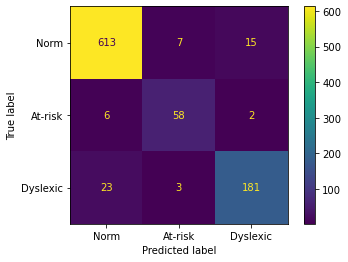

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


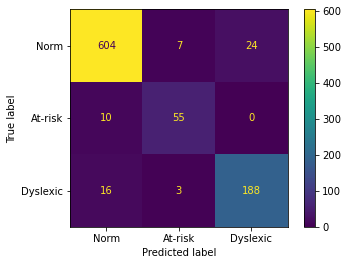

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


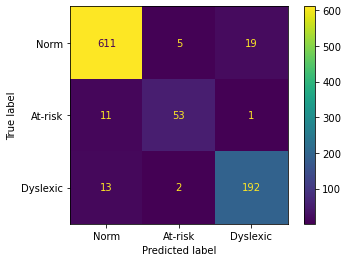

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


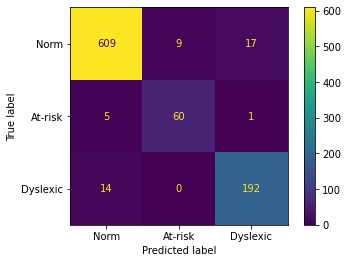

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


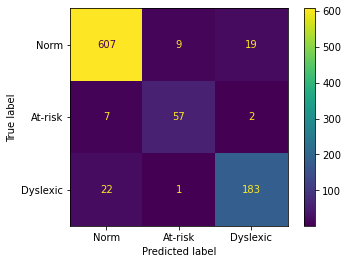

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


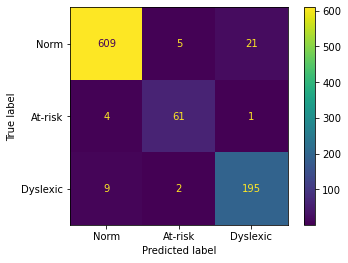

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


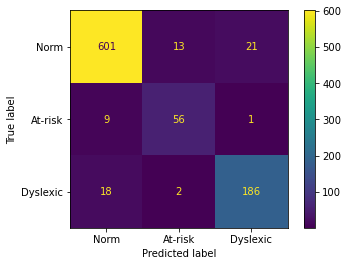

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


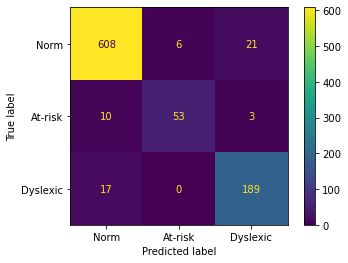

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


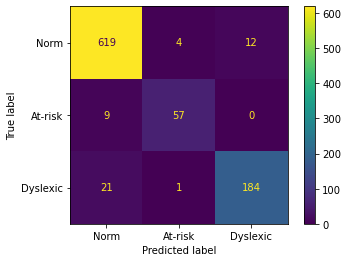

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


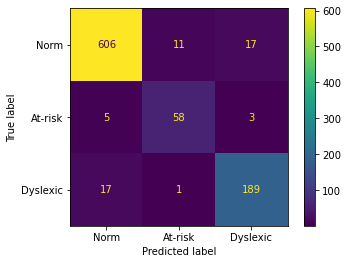

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [27]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [28]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.087 0.118 0.088 0.005 0.941 0.007 0.929 0.013


In [29]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08051D+00    |proj g|=  3.62918D-01

At iterate    1    f=  9.84217D-01    |proj g|=  2.27284D-01

At iterate    2    f=  7.76503D-01    |proj g|=  8.85687D-02

At iterate    3    f=  7.53340D-01    |proj g|=  6.32387D-02

At iterate    4    f=  7.42822D-01    |proj g|=  2.46896D-02

At iterate    5    f=  7.36644D-01    |proj g|=  1.69102D-02

At iterate    6    f=  7.26252D-01    |proj g|=  2.43080D-02

At iterate    7    f=  7.09281D-01    |proj g|=  3.33731D-02

At iterate    8    f=  6.93743D-01    |proj g|=  1.44173D-02

At iterate    9    f=  6.89319D-01    |proj g|=  2.30890D-02


 This problem is unconstrained.



At iterate   10    f=  6.85205D-01    |proj g|=  1.20461D-02

At iterate   11    f=  6.80352D-01    |proj g|=  1.69332D-02

At iterate   12    f=  6.71589D-01    |proj g|=  3.12686D-02

At iterate   13    f=  6.61334D-01    |proj g|=  1.83810D-02

At iterate   14    f=  6.48743D-01    |proj g|=  1.86890D-02

At iterate   15    f=  6.36373D-01    |proj g|=  2.49968D-02

At iterate   16    f=  6.24439D-01    |proj g|=  3.29264D-02

At iterate   17    f=  6.20672D-01    |proj g|=  1.54119D-02

At iterate   18    f=  6.18925D-01    |proj g|=  1.18189D-02

At iterate   19    f=  6.15411D-01    |proj g|=  8.91638D-03

At iterate   20    f=  6.10081D-01    |proj g|=  9.94078D-03

At iterate   21    f=  6.06132D-01    |proj g|=  1.19309D-02

At iterate   22    f=  6.03579D-01    |proj g|=  8.84912D-03

At iterate   23    f=  6.01507D-01    |proj g|=  5.42421D-03

At iterate   24    f=  6.00133D-01    |proj g|=  4.24112D-03

At iterate   25    f=  5.97111D-01    |proj g|=  6.37838D-03

At iter


At iterate  143    f=  4.15395D-01    |proj g|=  9.28530D-03

At iterate  144    f=  4.15034D-01    |proj g|=  7.86005D-03

At iterate  145    f=  4.14208D-01    |proj g|=  4.99566D-03

At iterate  146    f=  4.13527D-01    |proj g|=  3.71227D-03

At iterate  147    f=  4.12957D-01    |proj g|=  5.31538D-03

At iterate  148    f=  4.12430D-01    |proj g|=  1.40100D-02

At iterate  149    f=  4.11763D-01    |proj g|=  6.32592D-03

At iterate  150    f=  4.11206D-01    |proj g|=  5.20990D-03

At iterate  151    f=  4.09946D-01    |proj g|=  1.35734D-02

At iterate  152    f=  4.09271D-01    |proj g|=  7.35617D-03

At iterate  153    f=  4.08856D-01    |proj g|=  5.58588D-03

At iterate  154    f=  4.08054D-01    |proj g|=  5.90309D-03

At iterate  155    f=  4.07434D-01    |proj g|=  7.34393D-03

At iterate  156    f=  4.06616D-01    |proj g|=  2.36974D-02

At iterate  157    f=  4.05361D-01    |proj g|=  5.19687D-03

At iterate  158    f=  4.05022D-01    |proj g|=  5.39390D-03

At iter


At iterate  286    f=  3.22610D-01    |proj g|=  6.68362D-03

At iterate  287    f=  3.22102D-01    |proj g|=  7.98404D-03

At iterate  288    f=  3.21192D-01    |proj g|=  1.11635D-02

At iterate  289    f=  3.20667D-01    |proj g|=  7.92165D-03

At iterate  290    f=  3.20199D-01    |proj g|=  3.48966D-03

At iterate  291    f=  3.19682D-01    |proj g|=  6.17943D-03

At iterate  292    f=  3.19381D-01    |proj g|=  3.70284D-03

At iterate  293    f=  3.18897D-01    |proj g|=  4.04236D-03

At iterate  294    f=  3.18397D-01    |proj g|=  5.70765D-03

At iterate  295    f=  3.17825D-01    |proj g|=  5.10131D-03

At iterate  296    f=  3.17534D-01    |proj g|=  1.54691D-02

At iterate  297    f=  3.16835D-01    |proj g|=  8.65779D-03

At iterate  298    f=  3.16085D-01    |proj g|=  4.78157D-03

At iterate  299    f=  3.15594D-01    |proj g|=  5.04598D-03

At iterate  300    f=  3.14830D-01    |proj g|=  5.68117D-03

At iterate  301    f=  3.13828D-01    |proj g|=  9.94818D-03

At iter


At iterate  419    f=  2.64655D-01    |proj g|=  6.45171D-03

At iterate  420    f=  2.64333D-01    |proj g|=  4.42423D-03

At iterate  421    f=  2.64154D-01    |proj g|=  2.35564D-03

At iterate  422    f=  2.63892D-01    |proj g|=  4.09775D-03

At iterate  423    f=  2.63796D-01    |proj g|=  6.56149D-03

At iterate  424    f=  2.63663D-01    |proj g|=  4.62391D-03

At iterate  425    f=  2.63370D-01    |proj g|=  2.43682D-03

At iterate  426    f=  2.63177D-01    |proj g|=  2.85569D-03

At iterate  427    f=  2.62950D-01    |proj g|=  4.07891D-03

At iterate  428    f=  2.62670D-01    |proj g|=  4.34825D-03

At iterate  429    f=  2.62408D-01    |proj g|=  3.82828D-03

At iterate  430    f=  2.61962D-01    |proj g|=  2.42169D-03

At iterate  431    f=  2.61758D-01    |proj g|=  5.11884D-03

At iterate  432    f=  2.61454D-01    |proj g|=  3.89302D-03

At iterate  433    f=  2.61179D-01    |proj g|=  2.27287D-03

At iterate  434    f=  2.60881D-01    |proj g|=  4.91243D-03

At iter


At iterate  555    f=  2.34159D-01    |proj g|=  6.96231D-03

At iterate  556    f=  2.33983D-01    |proj g|=  3.62615D-03

At iterate  557    f=  2.33848D-01    |proj g|=  4.40531D-03

At iterate  558    f=  2.33736D-01    |proj g|=  3.60346D-03

At iterate  559    f=  2.33628D-01    |proj g|=  2.13203D-03

At iterate  560    f=  2.33489D-01    |proj g|=  2.17777D-03

At iterate  561    f=  2.33353D-01    |proj g|=  2.40601D-03

At iterate  562    f=  2.33110D-01    |proj g|=  4.54595D-03

At iterate  563    f=  2.32965D-01    |proj g|=  8.05489D-03

At iterate  564    f=  2.32730D-01    |proj g|=  2.07368D-03

At iterate  565    f=  2.32609D-01    |proj g|=  1.93655D-03

At iterate  566    f=  2.32503D-01    |proj g|=  3.29358D-03

At iterate  567    f=  2.32393D-01    |proj g|=  4.48765D-03

At iterate  568    f=  2.32271D-01    |proj g|=  2.65825D-03

At iterate  569    f=  2.32043D-01    |proj g|=  2.13820D-03

At iterate  570    f=  2.31809D-01    |proj g|=  2.81806D-03

At iter


At iterate  690    f=  2.10360D-01    |proj g|=  7.59953D-03

At iterate  691    f=  2.10244D-01    |proj g|=  2.04112D-03

At iterate  692    f=  2.10186D-01    |proj g|=  1.99367D-03

At iterate  693    f=  2.10090D-01    |proj g|=  3.85637D-03

At iterate  694    f=  2.09950D-01    |proj g|=  4.45412D-03

At iterate  695    f=  2.09899D-01    |proj g|=  4.47903D-03

At iterate  696    f=  2.09771D-01    |proj g|=  3.19821D-03

At iterate  697    f=  2.09656D-01    |proj g|=  1.94132D-03

At iterate  698    f=  2.09573D-01    |proj g|=  5.81271D-03

At iterate  699    f=  2.09478D-01    |proj g|=  2.07617D-03

At iterate  700    f=  2.09424D-01    |proj g|=  2.29073D-03

At iterate  701    f=  2.09328D-01    |proj g|=  2.78518D-03

At iterate  702    f=  2.09163D-01    |proj g|=  3.48950D-03

At iterate  703    f=  2.09069D-01    |proj g|=  8.36719D-03

At iterate  704    f=  2.08860D-01    |proj g|=  3.87489D-03

At iterate  705    f=  2.08693D-01    |proj g|=  2.70612D-03

At iter


At iterate  827    f=  1.94167D-01    |proj g|=  5.65858D-03

At iterate  828    f=  1.94069D-01    |proj g|=  3.75383D-03

At iterate  829    f=  1.93934D-01    |proj g|=  2.65171D-03

At iterate  830    f=  1.93791D-01    |proj g|=  3.32658D-03

At iterate  831    f=  1.93702D-01    |proj g|=  8.51415D-03

At iterate  832    f=  1.93516D-01    |proj g|=  3.30355D-03

At iterate  833    f=  1.93442D-01    |proj g|=  2.07510D-03

At iterate  834    f=  1.93367D-01    |proj g|=  2.71770D-03

At iterate  835    f=  1.93251D-01    |proj g|=  2.61332D-03

At iterate  836    f=  1.93160D-01    |proj g|=  9.62247D-03

At iterate  837    f=  1.92969D-01    |proj g|=  4.99692D-03

At iterate  838    f=  1.92809D-01    |proj g|=  2.07330D-03

At iterate  839    f=  1.92646D-01    |proj g|=  2.93690D-03

At iterate  840    f=  1.92492D-01    |proj g|=  6.79971D-03

At iterate  841    f=  1.92369D-01    |proj g|=  6.59216D-03

At iterate  842    f=  1.92198D-01    |proj g|=  2.95862D-03

At iter


At iterate  966    f=  1.80603D-01    |proj g|=  2.67300D-03

At iterate  967    f=  1.80517D-01    |proj g|=  2.54536D-03

At iterate  968    f=  1.80470D-01    |proj g|=  5.11426D-03

At iterate  969    f=  1.80415D-01    |proj g|=  2.41579D-03

At iterate  970    f=  1.80379D-01    |proj g|=  1.46115D-03

At iterate  971    f=  1.80339D-01    |proj g|=  1.79832D-03

At iterate  972    f=  1.80259D-01    |proj g|=  2.50117D-03

At iterate  973    f=  1.80183D-01    |proj g|=  7.43409D-03

At iterate  974    f=  1.80070D-01    |proj g|=  3.80226D-03

At iterate  975    f=  1.80014D-01    |proj g|=  1.82125D-03

At iterate  976    f=  1.79977D-01    |proj g|=  2.30524D-03

At iterate  977    f=  1.79933D-01    |proj g|=  3.92262D-03

At iterate  978    f=  1.79877D-01    |proj g|=  4.08903D-03

At iterate  979    f=  1.79793D-01    |proj g|=  6.24689D-03

At iterate  980    f=  1.79738D-01    |proj g|=  6.03461D-03

At iterate  981    f=  1.79692D-01    |proj g|=  2.75665D-03

At iter


At iterate 1101    f=  1.73858D-01    |proj g|=  2.46453D-03

At iterate 1102    f=  1.73791D-01    |proj g|=  2.18020D-03

At iterate 1103    f=  1.73740D-01    |proj g|=  6.34501D-03

At iterate 1104    f=  1.73649D-01    |proj g|=  3.70856D-03

At iterate 1105    f=  1.73596D-01    |proj g|=  2.73517D-03

At iterate 1106    f=  1.73546D-01    |proj g|=  3.25227D-03

At iterate 1107    f=  1.73468D-01    |proj g|=  4.49428D-03

At iterate 1108    f=  1.73425D-01    |proj g|=  2.89838D-03

At iterate 1109    f=  1.73390D-01    |proj g|=  1.91186D-03

At iterate 1110    f=  1.73354D-01    |proj g|=  1.95333D-03

At iterate 1111    f=  1.73301D-01    |proj g|=  2.79695D-03

At iterate 1112    f=  1.73215D-01    |proj g|=  3.65758D-03

At iterate 1113    f=  1.73159D-01    |proj g|=  6.48826D-03

At iterate 1114    f=  1.73097D-01    |proj g|=  2.44385D-03

At iterate 1115    f=  1.73041D-01    |proj g|=  2.14553D-03

At iterate 1116    f=  1.73005D-01    |proj g|=  3.14927D-03

At iter


At iterate 1235    f=  1.68209D-01    |proj g|=  2.55019D-03

At iterate 1236    f=  1.68184D-01    |proj g|=  4.09816D-03

At iterate 1237    f=  1.68153D-01    |proj g|=  1.98438D-03

At iterate 1238    f=  1.68135D-01    |proj g|=  2.16215D-03

At iterate 1239    f=  1.68120D-01    |proj g|=  1.91706D-03

At iterate 1240    f=  1.68081D-01    |proj g|=  2.22720D-03

At iterate 1241    f=  1.68024D-01    |proj g|=  3.80841D-03

At iterate 1242    f=  1.67974D-01    |proj g|=  4.04138D-03

At iterate 1243    f=  1.67930D-01    |proj g|=  2.55857D-03

At iterate 1244    f=  1.67899D-01    |proj g|=  1.84377D-03

At iterate 1245    f=  1.67875D-01    |proj g|=  1.90480D-03

At iterate 1246    f=  1.67813D-01    |proj g|=  1.99876D-03

At iterate 1247    f=  1.67767D-01    |proj g|=  2.56278D-03

At iterate 1248    f=  1.67733D-01    |proj g|=  2.79745D-03

At iterate 1249    f=  1.67711D-01    |proj g|=  1.65739D-03

At iterate 1250    f=  1.67689D-01    |proj g|=  3.81092D-03

At iter


At iterate 1375    f=  1.61299D-01    |proj g|=  2.74044D-03

At iterate 1376    f=  1.61274D-01    |proj g|=  2.13935D-03

At iterate 1377    f=  1.61218D-01    |proj g|=  2.05367D-03

At iterate 1378    f=  1.61156D-01    |proj g|=  2.59860D-03

At iterate 1379    f=  1.61141D-01    |proj g|=  7.42806D-03

At iterate 1380    f=  1.61064D-01    |proj g|=  3.18270D-03

At iterate 1381    f=  1.61038D-01    |proj g|=  1.80189D-03

At iterate 1382    f=  1.61010D-01    |proj g|=  1.60708D-03

At iterate 1383    f=  1.60960D-01    |proj g|=  2.71679D-03

At iterate 1384    f=  1.60905D-01    |proj g|=  2.75658D-03

At iterate 1385    f=  1.60857D-01    |proj g|=  3.90170D-03

At iterate 1386    f=  1.60822D-01    |proj g|=  2.35699D-03

At iterate 1387    f=  1.60792D-01    |proj g|=  2.30383D-03

At iterate 1388    f=  1.60751D-01    |proj g|=  2.47156D-03

At iterate 1389    f=  1.60675D-01    |proj g|=  3.06514D-03

At iterate 1390    f=  1.60648D-01    |proj g|=  6.74150D-03

At iter


At iterate 1511    f=  1.54716D-01    |proj g|=  1.52426D-03

At iterate 1512    f=  1.54690D-01    |proj g|=  1.66437D-03

At iterate 1513    f=  1.54659D-01    |proj g|=  1.92447D-03

At iterate 1514    f=  1.54614D-01    |proj g|=  3.61502D-03

At iterate 1515    f=  1.54581D-01    |proj g|=  8.39276D-03

At iterate 1516    f=  1.54506D-01    |proj g|=  2.62887D-03

At iterate 1517    f=  1.54472D-01    |proj g|=  2.61438D-03

At iterate 1518    f=  1.54424D-01    |proj g|=  2.09616D-03

At iterate 1519    f=  1.54397D-01    |proj g|=  4.93114D-03

At iterate 1520    f=  1.54340D-01    |proj g|=  2.42917D-03

At iterate 1521    f=  1.54298D-01    |proj g|=  1.38670D-03

At iterate 1522    f=  1.54260D-01    |proj g|=  1.78788D-03

At iterate 1523    f=  1.54212D-01    |proj g|=  3.20376D-03

At iterate 1524    f=  1.54159D-01    |proj g|=  8.31874D-03

At iterate 1525    f=  1.54076D-01    |proj g|=  3.35989D-03

At iterate 1526    f=  1.54024D-01    |proj g|=  3.37953D-03

At iter


At iterate 1663    f=  1.46837D-01    |proj g|=  2.16574D-03

At iterate 1664    f=  1.46809D-01    |proj g|=  2.91285D-03

At iterate 1665    f=  1.46776D-01    |proj g|=  2.95433D-03

At iterate 1666    f=  1.46736D-01    |proj g|=  2.60388D-03

At iterate 1667    f=  1.46703D-01    |proj g|=  2.00722D-03

At iterate 1668    f=  1.46641D-01    |proj g|=  6.11897D-03

At iterate 1669    f=  1.46602D-01    |proj g|=  3.66160D-03

At iterate 1670    f=  1.46568D-01    |proj g|=  2.02867D-03

At iterate 1671    f=  1.46518D-01    |proj g|=  2.52284D-03

At iterate 1672    f=  1.46473D-01    |proj g|=  3.29106D-03

At iterate 1673    f=  1.46349D-01    |proj g|=  4.56866D-03

At iterate 1674    f=  1.46304D-01    |proj g|=  5.08061D-03

At iterate 1675    f=  1.46244D-01    |proj g|=  1.86317D-03

At iterate 1676    f=  1.46193D-01    |proj g|=  1.97878D-03

At iterate 1677    f=  1.46134D-01    |proj g|=  6.37856D-03

At iterate 1678    f=  1.46078D-01    |proj g|=  3.10134D-03

At iter


At iterate 1816    f=  1.39967D-01    |proj g|=  2.21595D-03

At iterate 1817    f=  1.39949D-01    |proj g|=  2.94743D-03

At iterate 1818    f=  1.39912D-01    |proj g|=  4.80878D-03

At iterate 1819    f=  1.39870D-01    |proj g|=  2.94808D-03

At iterate 1820    f=  1.39845D-01    |proj g|=  2.54619D-03

At iterate 1821    f=  1.39800D-01    |proj g|=  1.88419D-03

At iterate 1822    f=  1.39756D-01    |proj g|=  2.14595D-03

At iterate 1823    f=  1.39713D-01    |proj g|=  5.84880D-03

At iterate 1824    f=  1.39646D-01    |proj g|=  3.41652D-03

At iterate 1825    f=  1.39627D-01    |proj g|=  2.25910D-03

At iterate 1826    f=  1.39609D-01    |proj g|=  1.90419D-03

At iterate 1827    f=  1.39581D-01    |proj g|=  5.92687D-03

At iterate 1828    f=  1.39547D-01    |proj g|=  4.15489D-03

At iterate 1829    f=  1.39500D-01    |proj g|=  1.69600D-03

At iterate 1830    f=  1.39481D-01    |proj g|=  1.84369D-03

At iterate 1831    f=  1.39437D-01    |proj g|=  3.94486D-03

At iter


At iterate 1957    f=  1.34188D-01    |proj g|=  1.91910D-03

At iterate 1958    f=  1.34167D-01    |proj g|=  2.14311D-03

At iterate 1959    f=  1.34132D-01    |proj g|=  5.85785D-03

At iterate 1960    f=  1.34099D-01    |proj g|=  3.72011D-03

At iterate 1961    f=  1.34074D-01    |proj g|=  2.07016D-03

At iterate 1962    f=  1.34035D-01    |proj g|=  2.58423D-03

At iterate 1963    f=  1.34006D-01    |proj g|=  2.68858D-03

At iterate 1964    f=  1.33970D-01    |proj g|=  5.16557D-03

At iterate 1965    f=  1.33919D-01    |proj g|=  2.14764D-03

At iterate 1966    f=  1.33899D-01    |proj g|=  1.86716D-03

At iterate 1967    f=  1.33865D-01    |proj g|=  6.36791D-03

At iterate 1968    f=  1.33841D-01    |proj g|=  2.85449D-03

At iterate 1969    f=  1.33817D-01    |proj g|=  2.21692D-03

At iterate 1970    f=  1.33755D-01    |proj g|=  2.41921D-03

At iterate 1971    f=  1.33709D-01    |proj g|=  2.93161D-03

At iterate 1972    f=  1.33668D-01    |proj g|=  4.97698D-03

At iter


At iterate 2098    f=  1.29095D-01    |proj g|=  4.17976D-03

At iterate 2099    f=  1.29032D-01    |proj g|=  1.81718D-03

At iterate 2100    f=  1.28982D-01    |proj g|=  2.03891D-03

At iterate 2101    f=  1.28949D-01    |proj g|=  7.64603D-03

At iterate 2102    f=  1.28896D-01    |proj g|=  2.90679D-03

At iterate 2103    f=  1.28848D-01    |proj g|=  1.95689D-03

At iterate 2104    f=  1.28810D-01    |proj g|=  6.39607D-03

At iterate 2105    f=  1.28778D-01    |proj g|=  2.87185D-03

At iterate 2106    f=  1.28757D-01    |proj g|=  1.46589D-03

At iterate 2107    f=  1.28735D-01    |proj g|=  2.22895D-03

At iterate 2108    f=  1.28704D-01    |proj g|=  2.13585D-03

At iterate 2109    f=  1.28656D-01    |proj g|=  1.92354D-03

At iterate 2110    f=  1.28594D-01    |proj g|=  2.51416D-03

At iterate 2111    f=  1.28541D-01    |proj g|=  4.54519D-03

At iterate 2112    f=  1.28466D-01    |proj g|=  2.18221D-03

At iterate 2113    f=  1.28426D-01    |proj g|=  2.35773D-03

At iter


At iterate 2251    f=  1.24380D-01    |proj g|=  1.96160D-03

At iterate 2252    f=  1.24361D-01    |proj g|=  3.53591D-03

At iterate 2253    f=  1.24341D-01    |proj g|=  1.97021D-03

At iterate 2254    f=  1.24325D-01    |proj g|=  1.38805D-03

At iterate 2255    f=  1.24309D-01    |proj g|=  1.47784D-03

At iterate 2256    f=  1.24273D-01    |proj g|=  2.68905D-03

At iterate 2257    f=  1.24262D-01    |proj g|=  3.86443D-03

At iterate 2258    f=  1.24233D-01    |proj g|=  1.44475D-03

At iterate 2259    f=  1.24215D-01    |proj g|=  1.52995D-03

At iterate 2260    f=  1.24200D-01    |proj g|=  4.97458D-03

At iterate 2261    f=  1.24176D-01    |proj g|=  1.67325D-03

At iterate 2262    f=  1.24160D-01    |proj g|=  2.01357D-03

At iterate 2263    f=  1.24129D-01    |proj g|=  2.81744D-03

At iterate 2264    f=  1.24088D-01    |proj g|=  3.13760D-03

At iterate 2265    f=  1.24059D-01    |proj g|=  4.86036D-03

At iterate 2266    f=  1.24026D-01    |proj g|=  3.07704D-03

At iter


At iterate 2405    f=  1.21363D-01    |proj g|=  2.49280D-03

At iterate 2406    f=  1.21337D-01    |proj g|=  2.83834D-03

At iterate 2407    f=  1.21317D-01    |proj g|=  1.96767D-03

At iterate 2408    f=  1.21304D-01    |proj g|=  1.69018D-03

At iterate 2409    f=  1.21289D-01    |proj g|=  1.74483D-03

At iterate 2410    f=  1.21274D-01    |proj g|=  9.26286D-03

At iterate 2411    f=  1.21247D-01    |proj g|=  4.74431D-03

At iterate 2412    f=  1.21223D-01    |proj g|=  1.34260D-03

At iterate 2413    f=  1.21214D-01    |proj g|=  1.41742D-03

At iterate 2414    f=  1.21195D-01    |proj g|=  3.49514D-03

At iterate 2415    f=  1.21177D-01    |proj g|=  7.35398D-03

At iterate 2416    f=  1.21156D-01    |proj g|=  1.35171D-03

At iterate 2417    f=  1.21145D-01    |proj g|=  2.01492D-03

At iterate 2418    f=  1.21135D-01    |proj g|=  2.21130D-03

At iterate 2419    f=  1.21123D-01    |proj g|=  3.73326D-03

At iterate 2420    f=  1.21103D-01    |proj g|=  1.33721D-03

At iter


At iterate 2561    f=  1.19204D-01    |proj g|=  1.53623D-03

At iterate 2562    f=  1.19186D-01    |proj g|=  1.73535D-03

At iterate 2563    f=  1.19176D-01    |proj g|=  2.25264D-03

At iterate 2564    f=  1.19165D-01    |proj g|=  1.22945D-03

At iterate 2565    f=  1.19159D-01    |proj g|=  1.12400D-03

At iterate 2566    f=  1.19151D-01    |proj g|=  1.21496D-03

At iterate 2567    f=  1.19135D-01    |proj g|=  1.57585D-03

At iterate 2568    f=  1.19119D-01    |proj g|=  4.47666D-03

At iterate 2569    f=  1.19095D-01    |proj g|=  2.27251D-03

At iterate 2570    f=  1.19078D-01    |proj g|=  1.66368D-03

At iterate 2571    f=  1.19071D-01    |proj g|=  6.81827D-03

At iterate 2572    f=  1.19058D-01    |proj g|=  1.38907D-03

At iterate 2573    f=  1.19048D-01    |proj g|=  1.60654D-03

At iterate 2574    f=  1.19032D-01    |proj g|=  2.22874D-03

At iterate 2575    f=  1.19002D-01    |proj g|=  4.28047D-03

At iterate 2576    f=  1.18983D-01    |proj g|=  3.86738D-03

At iter


At iterate 2713    f=  1.17268D-01    |proj g|=  1.14076D-03

At iterate 2714    f=  1.17257D-01    |proj g|=  1.46317D-03

At iterate 2715    f=  1.17247D-01    |proj g|=  3.04479D-03

At iterate 2716    f=  1.17232D-01    |proj g|=  1.06529D-03

At iterate 2717    f=  1.17223D-01    |proj g|=  1.19515D-03

At iterate 2718    f=  1.17201D-01    |proj g|=  1.38911D-03

At iterate 2719    f=  1.17194D-01    |proj g|=  5.35099D-03

At iterate 2720    f=  1.17177D-01    |proj g|=  1.55779D-03

At iterate 2721    f=  1.17165D-01    |proj g|=  1.28860D-03

At iterate 2722    f=  1.17152D-01    |proj g|=  9.74675D-04

At iterate 2723    f=  1.17139D-01    |proj g|=  8.21614D-04

At iterate 2724    f=  1.17130D-01    |proj g|=  3.63528D-03

At iterate 2725    f=  1.17115D-01    |proj g|=  1.11045D-03

At iterate 2726    f=  1.17105D-01    |proj g|=  9.96877D-04

At iterate 2727    f=  1.17090D-01    |proj g|=  2.08424D-03

At iterate 2728    f=  1.17084D-01    |proj g|=  2.24004D-03

At iter


At iterate 2862    f=  1.16147D-01    |proj g|=  3.83655D-03

At iterate 2863    f=  1.16138D-01    |proj g|=  1.15820D-03

At iterate 2864    f=  1.16135D-01    |proj g|=  1.33826D-03

At iterate 2865    f=  1.16129D-01    |proj g|=  1.46224D-03

At iterate 2866    f=  1.16119D-01    |proj g|=  3.90308D-03

At iterate 2867    f=  1.16110D-01    |proj g|=  2.82668D-03

At iterate 2868    f=  1.16102D-01    |proj g|=  2.01034D-03

At iterate 2869    f=  1.16094D-01    |proj g|=  1.25507D-03

At iterate 2870    f=  1.16087D-01    |proj g|=  1.47706D-03

At iterate 2871    f=  1.16083D-01    |proj g|=  2.59226D-03

At iterate 2872    f=  1.16075D-01    |proj g|=  1.24475D-03

At iterate 2873    f=  1.16072D-01    |proj g|=  6.81068D-04

At iterate 2874    f=  1.16066D-01    |proj g|=  1.22000D-03

At iterate 2875    f=  1.16061D-01    |proj g|=  1.35308D-03

At iterate 2876    f=  1.16059D-01    |proj g|=  3.39305D-03

At iterate 2877    f=  1.16053D-01    |proj g|=  9.60128D-04

At iter


At iterate 3011    f=  1.15010D-01    |proj g|=  1.79555D-03

At iterate 3012    f=  1.15004D-01    |proj g|=  2.66936D-03

At iterate 3013    f=  1.14996D-01    |proj g|=  1.79879D-03

At iterate 3014    f=  1.14987D-01    |proj g|=  1.43925D-03

At iterate 3015    f=  1.14977D-01    |proj g|=  2.66145D-03

At iterate 3016    f=  1.14974D-01    |proj g|=  5.29725D-03

At iterate 3017    f=  1.14955D-01    |proj g|=  1.53713D-03

At iterate 3018    f=  1.14949D-01    |proj g|=  1.13895D-03

At iterate 3019    f=  1.14940D-01    |proj g|=  1.51766D-03

At iterate 3020    f=  1.14927D-01    |proj g|=  1.97033D-03

At iterate 3021    f=  1.14919D-01    |proj g|=  2.73002D-03

At iterate 3022    f=  1.14911D-01    |proj g|=  1.14415D-03

At iterate 3023    f=  1.14906D-01    |proj g|=  9.61457D-04

At iterate 3024    f=  1.14894D-01    |proj g|=  1.98484D-03

At iterate 3025    f=  1.14887D-01    |proj g|=  4.11199D-03

At iterate 3026    f=  1.14873D-01    |proj g|=  2.47602D-03

At iter


At iterate 3155    f=  1.13619D-01    |proj g|=  1.63435D-03

At iterate 3156    f=  1.13608D-01    |proj g|=  5.09191D-03

At iterate 3157    f=  1.13596D-01    |proj g|=  2.28179D-03

At iterate 3158    f=  1.13588D-01    |proj g|=  1.31563D-03

At iterate 3159    f=  1.13579D-01    |proj g|=  2.20255D-03

At iterate 3160    f=  1.13568D-01    |proj g|=  2.45242D-03

At iterate 3161    f=  1.13558D-01    |proj g|=  8.00499D-03

At iterate 3162    f=  1.13538D-01    |proj g|=  3.72611D-03

At iterate 3163    f=  1.13527D-01    |proj g|=  1.20846D-03

At iterate 3164    f=  1.13517D-01    |proj g|=  1.99933D-03

At iterate 3165    f=  1.13505D-01    |proj g|=  2.93369D-03

At iterate 3166    f=  1.13499D-01    |proj g|=  7.57855D-03

At iterate 3167    f=  1.13473D-01    |proj g|=  2.74979D-03

At iterate 3168    f=  1.13462D-01    |proj g|=  1.29505D-03

At iterate 3169    f=  1.13452D-01    |proj g|=  1.94490D-03

At iterate 3170    f=  1.13443D-01    |proj g|=  3.06462D-03

At iter


At iterate 3288    f=  1.12348D-01    |proj g|=  1.53778D-03

At iterate 3289    f=  1.12341D-01    |proj g|=  1.24076D-03

At iterate 3290    f=  1.12334D-01    |proj g|=  4.18440D-03

At iterate 3291    f=  1.12325D-01    |proj g|=  2.57804D-03

At iterate 3292    f=  1.12316D-01    |proj g|=  2.06912D-03

At iterate 3293    f=  1.12308D-01    |proj g|=  8.86268D-04

At iterate 3294    f=  1.12301D-01    |proj g|=  1.44394D-03

At iterate 3295    f=  1.12291D-01    |proj g|=  5.27866D-03

At iterate 3296    f=  1.12282D-01    |proj g|=  2.60331D-03

At iterate 3297    f=  1.12275D-01    |proj g|=  1.32765D-03

At iterate 3298    f=  1.12266D-01    |proj g|=  1.14506D-03

At iterate 3299    f=  1.12253D-01    |proj g|=  1.54998D-03

At iterate 3300    f=  1.12241D-01    |proj g|=  1.89220D-03

At iterate 3301    f=  1.12236D-01    |proj g|=  1.78879D-03

At iterate 3302    f=  1.12230D-01    |proj g|=  1.25347D-03

At iterate 3303    f=  1.12225D-01    |proj g|=  1.15074D-03

At iter


At iterate 3436    f=  1.11357D-01    |proj g|=  2.14206D-03

At iterate 3437    f=  1.11351D-01    |proj g|=  7.69000D-04

At iterate 3438    f=  1.11348D-01    |proj g|=  5.53896D-04

At iterate 3439    f=  1.11344D-01    |proj g|=  8.93922D-04

At iterate 3440    f=  1.11339D-01    |proj g|=  1.85233D-03

At iterate 3441    f=  1.11335D-01    |proj g|=  3.51679D-03

At iterate 3442    f=  1.11330D-01    |proj g|=  8.02703D-04

At iterate 3443    f=  1.11327D-01    |proj g|=  1.48031D-03

At iterate 3444    f=  1.11321D-01    |proj g|=  2.08007D-03

At iterate 3445    f=  1.11316D-01    |proj g|=  2.12422D-03

At iterate 3446    f=  1.11310D-01    |proj g|=  7.21703D-04

At iterate 3447    f=  1.11307D-01    |proj g|=  8.98167D-04

At iterate 3448    f=  1.11303D-01    |proj g|=  2.73559D-03

At iterate 3449    f=  1.11295D-01    |proj g|=  2.43246D-03

At iterate 3450    f=  1.11284D-01    |proj g|=  1.47251D-03

At iterate 3451    f=  1.11271D-01    |proj g|=  1.16619D-03

At iter


At iterate 3575    f=  1.10256D-01    |proj g|=  2.07935D-03

At iterate 3576    f=  1.10249D-01    |proj g|=  1.62752D-03

At iterate 3577    f=  1.10242D-01    |proj g|=  1.93267D-03

At iterate 3578    f=  1.10235D-01    |proj g|=  1.75015D-03

At iterate 3579    f=  1.10229D-01    |proj g|=  4.29321D-03

At iterate 3580    f=  1.10221D-01    |proj g|=  1.50218D-03

At iterate 3581    f=  1.10216D-01    |proj g|=  1.42008D-03

At iterate 3582    f=  1.10207D-01    |proj g|=  1.61484D-03

At iterate 3583    f=  1.10194D-01    |proj g|=  2.04492D-03

At iterate 3584    f=  1.10189D-01    |proj g|=  3.23250D-03

At iterate 3585    f=  1.10180D-01    |proj g|=  1.27778D-03

At iterate 3586    f=  1.10174D-01    |proj g|=  1.33378D-03

At iterate 3587    f=  1.10165D-01    |proj g|=  1.24048D-03

At iterate 3588    f=  1.10154D-01    |proj g|=  2.65558D-03

At iterate 3589    f=  1.10144D-01    |proj g|=  4.78392D-03

At iterate 3590    f=  1.10132D-01    |proj g|=  2.32926D-03

At iter


At iterate 3711    f=  1.09366D-01    |proj g|=  2.62237D-03

At iterate 3712    f=  1.09361D-01    |proj g|=  1.89972D-03

At iterate 3713    f=  1.09349D-01    |proj g|=  1.05400D-03

At iterate 3714    f=  1.09343D-01    |proj g|=  4.48728D-03

At iterate 3715    f=  1.09334D-01    |proj g|=  1.88109D-03

At iterate 3716    f=  1.09328D-01    |proj g|=  1.11997D-03

At iterate 3717    f=  1.09323D-01    |proj g|=  1.33116D-03

At iterate 3718    f=  1.09314D-01    |proj g|=  1.38847D-03

At iterate 3719    f=  1.09310D-01    |proj g|=  2.43603D-03

At iterate 3720    f=  1.09303D-01    |proj g|=  1.67677D-03

At iterate 3721    f=  1.09298D-01    |proj g|=  1.09774D-03

At iterate 3722    f=  1.09290D-01    |proj g|=  1.14793D-03

At iterate 3723    f=  1.09288D-01    |proj g|=  3.68344D-03

At iterate 3724    f=  1.09284D-01    |proj g|=  1.85631D-03

At iterate 3725    f=  1.09280D-01    |proj g|=  7.61550D-04

At iterate 3726    f=  1.09272D-01    |proj g|=  1.40098D-03

At iter


At iterate 3849    f=  1.08405D-01    |proj g|=  1.00705D-03

At iterate 3850    f=  1.08395D-01    |proj g|=  1.90777D-03

At iterate 3851    f=  1.08391D-01    |proj g|=  7.82764D-03

At iterate 3852    f=  1.08382D-01    |proj g|=  3.69196D-03

At iterate 3853    f=  1.08371D-01    |proj g|=  1.73770D-03

At iterate 3854    f=  1.08363D-01    |proj g|=  2.52487D-03

At iterate 3855    f=  1.08353D-01    |proj g|=  2.84347D-03

At iterate 3856    f=  1.08349D-01    |proj g|=  4.94236D-03

At iterate 3857    f=  1.08337D-01    |proj g|=  2.56535D-03

At iterate 3858    f=  1.08329D-01    |proj g|=  1.07166D-03

At iterate 3859    f=  1.08322D-01    |proj g|=  1.37518D-03

At iterate 3860    f=  1.08315D-01    |proj g|=  1.86901D-03

At iterate 3861    f=  1.08307D-01    |proj g|=  5.27502D-03

At iterate 3862    f=  1.08297D-01    |proj g|=  2.00880D-03

At iterate 3863    f=  1.08291D-01    |proj g|=  1.16924D-03

At iterate 3864    f=  1.08282D-01    |proj g|=  1.62563D-03

At iter


At iterate 3986    f=  1.07620D-01    |proj g|=  2.72346D-03

At iterate 3987    f=  1.07614D-01    |proj g|=  1.73917D-03

At iterate 3988    f=  1.07609D-01    |proj g|=  2.10525D-03

At iterate 3989    f=  1.07607D-01    |proj g|=  2.21357D-03

At iterate 3990    f=  1.07604D-01    |proj g|=  1.54828D-03

At iterate 3991    f=  1.07599D-01    |proj g|=  1.36236D-03

At iterate 3992    f=  1.07592D-01    |proj g|=  1.26812D-03

At iterate 3993    f=  1.07585D-01    |proj g|=  1.29180D-03

At iterate 3994    f=  1.07583D-01    |proj g|=  2.98364D-03

At iterate 3995    f=  1.07573D-01    |proj g|=  2.56512D-03

At iterate 3996    f=  1.07571D-01    |proj g|=  1.00704D-03

At iterate 3997    f=  1.07570D-01    |proj g|=  5.41806D-04

At iterate 3998    f=  1.07568D-01    |proj g|=  5.37295D-04

At iterate 3999    f=  1.07568D-01    |proj g|=  1.95952D-03

At iterate 4000    f=  1.07566D-01    |proj g|=  9.19128D-04

At iterate 4001    f=  1.07563D-01    |proj g|=  6.17032D-04

At iter


At iterate 4133    f=  1.07023D-01    |proj g|=  9.21560D-04

At iterate 4134    f=  1.07020D-01    |proj g|=  1.04798D-03

At iterate 4135    f=  1.07016D-01    |proj g|=  2.46384D-03

At iterate 4136    f=  1.07010D-01    |proj g|=  1.79194D-03

At iterate 4137    f=  1.07004D-01    |proj g|=  1.54066D-03

At iterate 4138    f=  1.06999D-01    |proj g|=  1.42619D-03

At iterate 4139    f=  1.06996D-01    |proj g|=  1.76448D-03

At iterate 4140    f=  1.06992D-01    |proj g|=  1.57482D-03

At iterate 4141    f=  1.06981D-01    |proj g|=  1.81896D-03

At iterate 4142    f=  1.06973D-01    |proj g|=  1.72211D-03

At iterate 4143    f=  1.06970D-01    |proj g|=  2.01611D-03

At iterate 4144    f=  1.06967D-01    |proj g|=  9.20282D-04

At iterate 4145    f=  1.06966D-01    |proj g|=  7.09298D-04

At iterate 4146    f=  1.06960D-01    |proj g|=  1.22249D-03

At iterate 4147    f=  1.06954D-01    |proj g|=  1.77407D-03

At iterate 4148    f=  1.06951D-01    |proj g|=  2.60639D-03

At iter


At iterate 4272    f=  1.06454D-01    |proj g|=  3.81257D-03

At iterate 4273    f=  1.06448D-01    |proj g|=  1.32929D-03

At iterate 4274    f=  1.06447D-01    |proj g|=  6.37573D-04

At iterate 4275    f=  1.06444D-01    |proj g|=  1.10668D-03

At iterate 4276    f=  1.06442D-01    |proj g|=  2.59744D-03

At iterate 4277    f=  1.06439D-01    |proj g|=  1.22999D-03

At iterate 4278    f=  1.06435D-01    |proj g|=  1.25120D-03

At iterate 4279    f=  1.06430D-01    |proj g|=  1.29806D-03

At iterate 4280    f=  1.06429D-01    |proj g|=  2.33355D-03

At iterate 4281    f=  1.06425D-01    |proj g|=  1.68955D-03

At iterate 4282    f=  1.06421D-01    |proj g|=  1.08519D-03

At iterate 4283    f=  1.06415D-01    |proj g|=  1.47841D-03

At iterate 4284    f=  1.06407D-01    |proj g|=  1.94674D-03

At iterate 4285    f=  1.06405D-01    |proj g|=  2.56956D-03

At iterate 4286    f=  1.06399D-01    |proj g|=  1.52711D-03

At iterate 4287    f=  1.06395D-01    |proj g|=  9.29548D-04

At iter


At iterate 4430    f=  1.05819D-01    |proj g|=  1.29549D-03

At iterate 4431    f=  1.05813D-01    |proj g|=  9.22799D-04

At iterate 4432    f=  1.05806D-01    |proj g|=  9.53203D-04

At iterate 4433    f=  1.05798D-01    |proj g|=  1.11086D-03

At iterate 4434    f=  1.05789D-01    |proj g|=  1.86050D-03

At iterate 4435    f=  1.05779D-01    |proj g|=  2.22853D-03

At iterate 4436    f=  1.05775D-01    |proj g|=  3.76087D-03

At iterate 4437    f=  1.05768D-01    |proj g|=  1.90755D-03

At iterate 4438    f=  1.05766D-01    |proj g|=  1.68215D-03

At iterate 4439    f=  1.05763D-01    |proj g|=  1.44321D-03

At iterate 4440    f=  1.05758D-01    |proj g|=  2.32339D-03

At iterate 4441    f=  1.05753D-01    |proj g|=  2.23485D-03

At iterate 4442    f=  1.05749D-01    |proj g|=  1.20120D-03

At iterate 4443    f=  1.05746D-01    |proj g|=  1.34756D-03

At iterate 4444    f=  1.05742D-01    |proj g|=  1.62537D-03

At iterate 4445    f=  1.05735D-01    |proj g|=  1.83721D-03

At iter


At iterate 4575    f=  1.04976D-01    |proj g|=  2.22064D-03

At iterate 4576    f=  1.04970D-01    |proj g|=  1.60847D-03

At iterate 4577    f=  1.04967D-01    |proj g|=  5.98699D-03

At iterate 4578    f=  1.04962D-01    |proj g|=  2.25349D-03

At iterate 4579    f=  1.04958D-01    |proj g|=  1.63906D-03

At iterate 4580    f=  1.04956D-01    |proj g|=  2.57322D-03

At iterate 4581    f=  1.04950D-01    |proj g|=  3.05848D-03

At iterate 4582    f=  1.04942D-01    |proj g|=  2.53931D-03

At iterate 4583    f=  1.04940D-01    |proj g|=  2.85314D-03

At iterate 4584    f=  1.04936D-01    |proj g|=  1.01371D-03

At iterate 4585    f=  1.04933D-01    |proj g|=  1.97730D-03

At iterate 4586    f=  1.04930D-01    |proj g|=  3.11011D-03

At iterate 4587    f=  1.04925D-01    |proj g|=  2.86003D-03

At iterate 4588    f=  1.04917D-01    |proj g|=  2.69857D-03

At iterate 4589    f=  1.04907D-01    |proj g|=  2.53315D-03

At iterate 4590    f=  1.04899D-01    |proj g|=  2.41100D-03

At iter


At iterate 4710    f=  1.04419D-01    |proj g|=  1.02051D-03

At iterate 4711    f=  1.04415D-01    |proj g|=  3.82821D-03

At iterate 4712    f=  1.04410D-01    |proj g|=  1.54728D-03

At iterate 4713    f=  1.04406D-01    |proj g|=  1.51085D-03

At iterate 4714    f=  1.04402D-01    |proj g|=  1.50113D-03

At iterate 4715    f=  1.04396D-01    |proj g|=  1.53650D-03

At iterate 4716    f=  1.04385D-01    |proj g|=  2.44045D-03

At iterate 4717    f=  1.04382D-01    |proj g|=  4.21833D-03

At iterate 4718    f=  1.04374D-01    |proj g|=  8.83742D-04

At iterate 4719    f=  1.04370D-01    |proj g|=  1.08455D-03

At iterate 4720    f=  1.04365D-01    |proj g|=  2.78740D-03

At iterate 4721    f=  1.04361D-01    |proj g|=  1.47704D-03

At iterate 4722    f=  1.04357D-01    |proj g|=  1.08146D-03

At iterate 4723    f=  1.04353D-01    |proj g|=  1.25164D-03

At iterate 4724    f=  1.04351D-01    |proj g|=  1.61618D-03

At iterate 4725    f=  1.04350D-01    |proj g|=  9.38308D-04

At iter


At iterate 4856    f=  1.03394D-01    |proj g|=  1.59373D-03

At iterate 4857    f=  1.03390D-01    |proj g|=  1.33681D-03

At iterate 4858    f=  1.03385D-01    |proj g|=  2.78888D-03

At iterate 4859    f=  1.03379D-01    |proj g|=  2.09773D-03

At iterate 4860    f=  1.03374D-01    |proj g|=  1.51634D-03

At iterate 4861    f=  1.03370D-01    |proj g|=  1.76893D-03

At iterate 4862    f=  1.03367D-01    |proj g|=  3.38220D-03

At iterate 4863    f=  1.03363D-01    |proj g|=  1.98943D-03

At iterate 4864    f=  1.03355D-01    |proj g|=  2.20234D-03

At iterate 4865    f=  1.03348D-01    |proj g|=  2.48700D-03

At iterate 4866    f=  1.03346D-01    |proj g|=  3.41710D-03

At iterate 4867    f=  1.03341D-01    |proj g|=  1.84079D-03

At iterate 4868    f=  1.03337D-01    |proj g|=  2.01382D-03

At iterate 4869    f=  1.03333D-01    |proj g|=  2.53516D-03

At iterate 4870    f=  1.03326D-01    |proj g|=  3.03162D-03

At iterate 4871    f=  1.03313D-01    |proj g|=  3.97944D-03

At iter


At iterate 4995    f=  1.02367D-01    |proj g|=  2.82278D-03

At iterate 4996    f=  1.02361D-01    |proj g|=  3.58635D-03

At iterate 4997    f=  1.02355D-01    |proj g|=  1.75713D-03

At iterate 4998    f=  1.02347D-01    |proj g|=  1.85536D-03

At iterate 4999    f=  1.02343D-01    |proj g|=  1.92191D-03

At iterate 5000    f=  1.02339D-01    |proj g|=  3.69870D-03

At iterate 5001    f=  1.02333D-01    |proj g|=  1.82107D-03

At iterate 5002    f=  1.02330D-01    |proj g|=  2.22755D-03

At iterate 5003    f=  1.02326D-01    |proj g|=  2.24377D-03

At iterate 5004    f=  1.02318D-01    |proj g|=  2.84803D-03

At iterate 5005    f=  1.02312D-01    |proj g|=  3.16811D-03

At iterate 5006    f=  1.02302D-01    |proj g|=  1.54598D-03

At iterate 5007    f=  1.02297D-01    |proj g|=  1.22344D-03

At iterate 5008    f=  1.02290D-01    |proj g|=  2.82162D-03

At iterate 5009    f=  1.02285D-01    |proj g|=  2.12873D-03

At iterate 5010    f=  1.02280D-01    |proj g|=  1.36364D-03

At iter


At iterate 5130    f=  1.01124D-01    |proj g|=  3.32596D-03

At iterate 5131    f=  1.01116D-01    |proj g|=  3.13805D-03

At iterate 5132    f=  1.01104D-01    |proj g|=  5.43514D-03

At iterate 5133    f=  1.01088D-01    |proj g|=  1.88106D-03

At iterate 5134    f=  1.01078D-01    |proj g|=  1.33770D-03

At iterate 5135    f=  1.01064D-01    |proj g|=  1.83942D-03

At iterate 5136    f=  1.01056D-01    |proj g|=  4.69772D-03

At iterate 5137    f=  1.01045D-01    |proj g|=  1.71313D-03

At iterate 5138    f=  1.01039D-01    |proj g|=  2.10850D-03

At iterate 5139    f=  1.01028D-01    |proj g|=  2.16291D-03

At iterate 5140    f=  1.01014D-01    |proj g|=  8.11167D-03

At iterate 5141    f=  1.00995D-01    |proj g|=  4.42370D-03

At iterate 5142    f=  1.00983D-01    |proj g|=  1.69908D-03

At iterate 5143    f=  1.00977D-01    |proj g|=  1.38261D-03

At iterate 5144    f=  1.00969D-01    |proj g|=  1.68422D-03

At iterate 5145    f=  1.00968D-01    |proj g|=  7.71281D-03

At iter


At iterate 5281    f=  9.92226D-02    |proj g|=  3.50481D-03

At iterate 5282    f=  9.92166D-02    |proj g|=  1.95449D-03

At iterate 5283    f=  9.92098D-02    |proj g|=  1.55971D-03

At iterate 5284    f=  9.91987D-02    |proj g|=  2.97526D-03

At iterate 5285    f=  9.91845D-02    |proj g|=  2.96447D-03

At iterate 5286    f=  9.91652D-02    |proj g|=  5.86741D-03

At iterate 5287    f=  9.91434D-02    |proj g|=  1.66494D-03

At iterate 5288    f=  9.91299D-02    |proj g|=  1.20487D-03

At iterate 5289    f=  9.91164D-02    |proj g|=  2.25635D-03

At iterate 5290    f=  9.91125D-02    |proj g|=  3.39185D-03

At iterate 5291    f=  9.91067D-02    |proj g|=  1.52033D-03

At iterate 5292    f=  9.90969D-02    |proj g|=  1.20940D-03

At iterate 5293    f=  9.90807D-02    |proj g|=  2.24680D-03

At iterate 5294    f=  9.90740D-02    |proj g|=  4.53599D-03

At iterate 5295    f=  9.90606D-02    |proj g|=  1.27824D-03

At iterate 5296    f=  9.90526D-02    |proj g|=  1.28087D-03

At iter


At iterate 5425    f=  9.79608D-02    |proj g|=  1.52495D-03

At iterate 5426    f=  9.79552D-02    |proj g|=  2.85088D-03

At iterate 5427    f=  9.79483D-02    |proj g|=  2.16129D-03

At iterate 5428    f=  9.79372D-02    |proj g|=  1.54862D-03

At iterate 5429    f=  9.79346D-02    |proj g|=  3.35482D-03

At iterate 5430    f=  9.79311D-02    |proj g|=  1.55070D-03

At iterate 5431    f=  9.79269D-02    |proj g|=  1.32713D-03

At iterate 5432    f=  9.79227D-02    |proj g|=  1.52550D-03

At iterate 5433    f=  9.79148D-02    |proj g|=  1.79801D-03

At iterate 5434    f=  9.79110D-02    |proj g|=  2.50683D-03

At iterate 5435    f=  9.79064D-02    |proj g|=  1.39481D-03

At iterate 5436    f=  9.79013D-02    |proj g|=  1.32261D-03

At iterate 5437    f=  9.78950D-02    |proj g|=  1.98988D-03

At iterate 5438    f=  9.78838D-02    |proj g|=  1.76764D-03

At iterate 5439    f=  9.78787D-02    |proj g|=  4.00384D-03

At iterate 5440    f=  9.78709D-02    |proj g|=  2.50229D-03

At iter


At iterate 5561    f=  9.72220D-02    |proj g|=  7.97394D-04

At iterate 5562    f=  9.72181D-02    |proj g|=  1.32725D-03

At iterate 5563    f=  9.72165D-02    |proj g|=  4.78455D-03

At iterate 5564    f=  9.72116D-02    |proj g|=  1.03235D-03

At iterate 5565    f=  9.72090D-02    |proj g|=  7.86872D-04

At iterate 5566    f=  9.72063D-02    |proj g|=  1.33955D-03

At iterate 5567    f=  9.72037D-02    |proj g|=  2.59475D-03

At iterate 5568    f=  9.72003D-02    |proj g|=  9.97235D-04

At iterate 5569    f=  9.71987D-02    |proj g|=  6.10314D-04

At iterate 5570    f=  9.71964D-02    |proj g|=  1.08312D-03

At iterate 5571    f=  9.71933D-02    |proj g|=  1.14937D-03

At iterate 5572    f=  9.71925D-02    |proj g|=  2.38915D-03

At iterate 5573    f=  9.71898D-02    |proj g|=  1.16394D-03

At iterate 5574    f=  9.71866D-02    |proj g|=  9.23936D-04

At iterate 5575    f=  9.71801D-02    |proj g|=  1.20696D-03

At iterate 5576    f=  9.71749D-02    |proj g|=  1.14861D-03

At iter


At iterate 5717    f=  9.67632D-02    |proj g|=  9.52677D-04

At iterate 5718    f=  9.67617D-02    |proj g|=  8.18681D-04

At iterate 5719    f=  9.67590D-02    |proj g|=  1.95810D-03

At iterate 5720    f=  9.67555D-02    |proj g|=  1.15689D-03

At iterate 5721    f=  9.67529D-02    |proj g|=  1.06860D-03

At iterate 5722    f=  9.67486D-02    |proj g|=  1.23462D-03

At iterate 5723    f=  9.67475D-02    |proj g|=  3.28514D-03

At iterate 5724    f=  9.67449D-02    |proj g|=  9.47295D-04

At iterate 5725    f=  9.67435D-02    |proj g|=  7.39012D-04

At iterate 5726    f=  9.67416D-02    |proj g|=  1.02387D-03

At iterate 5727    f=  9.67376D-02    |proj g|=  1.44895D-03

At iterate 5728    f=  9.67359D-02    |proj g|=  2.00621D-03

At iterate 5729    f=  9.67326D-02    |proj g|=  8.64826D-04

At iterate 5730    f=  9.67306D-02    |proj g|=  6.44089D-04

At iterate 5731    f=  9.67294D-02    |proj g|=  3.48210D-03

At iterate 5732    f=  9.67273D-02    |proj g|=  9.66424D-04

At iter


At iterate 5863    f=  9.62334D-02    |proj g|=  1.14796D-03

At iterate 5864    f=  9.62290D-02    |proj g|=  1.85489D-03

At iterate 5865    f=  9.62263D-02    |proj g|=  1.30921D-03

At iterate 5866    f=  9.62237D-02    |proj g|=  1.02006D-03

At iterate 5867    f=  9.62194D-02    |proj g|=  1.34600D-03

At iterate 5868    f=  9.62153D-02    |proj g|=  1.74277D-03

At iterate 5869    f=  9.62136D-02    |proj g|=  4.16837D-03

At iterate 5870    f=  9.62093D-02    |proj g|=  1.97500D-03

At iterate 5871    f=  9.62064D-02    |proj g|=  9.97032D-04

At iterate 5872    f=  9.62023D-02    |proj g|=  1.62441D-03

At iterate 5873    f=  9.61977D-02    |proj g|=  1.96665D-03

At iterate 5874    f=  9.61954D-02    |proj g|=  5.49469D-03

At iterate 5875    f=  9.61899D-02    |proj g|=  1.96194D-03

At iterate 5876    f=  9.61875D-02    |proj g|=  9.35791D-04

At iterate 5877    f=  9.61862D-02    |proj g|=  1.14523D-03

At iterate 5878    f=  9.61826D-02    |proj g|=  1.72246D-03

At iter

At iterate 6007    f=  9.57616D-02    |proj g|=  1.68787D-03

At iterate 6008    f=  9.57596D-02    |proj g|=  7.08020D-04

At iterate 6009    f=  9.57574D-02    |proj g|=  7.20415D-04

At iterate 6010    f=  9.57549D-02    |proj g|=  1.18907D-03

At iterate 6011    f=  9.57501D-02    |proj g|=  2.71692D-03

At iterate 6012    f=  9.57474D-02    |proj g|=  2.20309D-03

At iterate 6013    f=  9.57453D-02    |proj g|=  8.70788D-04

At iterate 6014    f=  9.57439D-02    |proj g|=  7.43502D-04

At iterate 6015    f=  9.57424D-02    |proj g|=  1.09949D-03

At iterate 6016    f=  9.57375D-02    |proj g|=  1.01635D-03

At iterate 6017    f=  9.57360D-02    |proj g|=  2.59377D-03

At iterate 6018    f=  9.57333D-02    |proj g|=  1.30464D-03

At iterate 6019    f=  9.57304D-02    |proj g|=  8.12354D-04

At iterate 6020    f=  9.57288D-02    |proj g|=  1.24463D-03

At iterate 6021    f=  9.57243D-02    |proj g|=  1.76561D-03

At iterate 6022    f=  9.57211D-02    |proj g|=  3.75002D-03

At itera


At iterate 6145    f=  9.53150D-02    |proj g|=  1.35888D-03

At iterate 6146    f=  9.53132D-02    |proj g|=  8.39474D-04

At iterate 6147    f=  9.53099D-02    |proj g|=  9.03306D-04

At iterate 6148    f=  9.53076D-02    |proj g|=  1.77304D-03

At iterate 6149    f=  9.53049D-02    |proj g|=  1.11080D-03

At iterate 6150    f=  9.53029D-02    |proj g|=  9.50494D-04

At iterate 6151    f=  9.53012D-02    |proj g|=  4.88565D-03

At iterate 6152    f=  9.52977D-02    |proj g|=  1.73176D-03

At iterate 6153    f=  9.52961D-02    |proj g|=  1.15637D-03

At iterate 6154    f=  9.52937D-02    |proj g|=  1.10368D-03

At iterate 6155    f=  9.52927D-02    |proj g|=  5.75523D-04

At iterate 6156    f=  9.52911D-02    |proj g|=  1.51548D-03

At iterate 6157    f=  9.52897D-02    |proj g|=  2.58980D-03

At iterate 6158    f=  9.52884D-02    |proj g|=  1.91604D-03

At iterate 6159    f=  9.52851D-02    |proj g|=  6.69186D-04

At iterate 6160    f=  9.52839D-02    |proj g|=  7.38929D-04

At iter


At iterate 6293    f=  9.48895D-02    |proj g|=  1.76224D-03

At iterate 6294    f=  9.48866D-02    |proj g|=  7.84691D-04

At iterate 6295    f=  9.48845D-02    |proj g|=  1.16217D-03

At iterate 6296    f=  9.48832D-02    |proj g|=  1.59724D-03

At iterate 6297    f=  9.48813D-02    |proj g|=  1.17517D-03

At iterate 6298    f=  9.48778D-02    |proj g|=  1.68117D-03

At iterate 6299    f=  9.48752D-02    |proj g|=  1.41234D-03

At iterate 6300    f=  9.48737D-02    |proj g|=  1.81090D-03

At iterate 6301    f=  9.48717D-02    |proj g|=  1.03981D-03

At iterate 6302    f=  9.48693D-02    |proj g|=  1.06328D-03

At iterate 6303    f=  9.48676D-02    |proj g|=  1.18770D-03

At iterate 6304    f=  9.48634D-02    |proj g|=  1.34792D-03

At iterate 6305    f=  9.48583D-02    |proj g|=  4.85430D-03

At iterate 6306    f=  9.48499D-02    |proj g|=  1.24771D-03

At iterate 6307    f=  9.48456D-02    |proj g|=  9.81099D-04

At iterate 6308    f=  9.48418D-02    |proj g|=  1.77061D-03

At iter


At iterate 6436    f=  9.43790D-02    |proj g|=  1.23769D-03

At iterate 6437    f=  9.43765D-02    |proj g|=  1.21632D-03

At iterate 6438    f=  9.43725D-02    |proj g|=  2.25037D-03

At iterate 6439    f=  9.43683D-02    |proj g|=  2.17767D-03

At iterate 6440    f=  9.43658D-02    |proj g|=  2.76862D-03

At iterate 6441    f=  9.43608D-02    |proj g|=  1.62603D-03

At iterate 6442    f=  9.43566D-02    |proj g|=  1.42138D-03

At iterate 6443    f=  9.43515D-02    |proj g|=  2.16243D-03

At iterate 6444    f=  9.43486D-02    |proj g|=  5.07103D-03

At iterate 6445    f=  9.43438D-02    |proj g|=  1.37243D-03

At iterate 6446    f=  9.43425D-02    |proj g|=  7.88893D-04

At iterate 6447    f=  9.43413D-02    |proj g|=  1.06296D-03

At iterate 6448    f=  9.43398D-02    |proj g|=  1.38631D-03

At iterate 6449    f=  9.43380D-02    |proj g|=  4.76939D-03

At iterate 6450    f=  9.43344D-02    |proj g|=  1.57852D-03

At iterate 6451    f=  9.43328D-02    |proj g|=  1.10812D-03

At iter


At iterate 6590    f=  9.39514D-02    |proj g|=  2.13964D-03

At iterate 6591    f=  9.39488D-02    |proj g|=  6.12552D-03

At iterate 6592    f=  9.39419D-02    |proj g|=  1.63974D-03

At iterate 6593    f=  9.39378D-02    |proj g|=  8.74407D-04

At iterate 6594    f=  9.39341D-02    |proj g|=  1.87528D-03

At iterate 6595    f=  9.39320D-02    |proj g|=  2.63564D-03

At iterate 6596    f=  9.39285D-02    |proj g|=  7.97683D-04

At iterate 6597    f=  9.39265D-02    |proj g|=  7.75797D-04

At iterate 6598    f=  9.39229D-02    |proj g|=  9.85191D-04

At iterate 6599    f=  9.39190D-02    |proj g|=  2.78451D-03

At iterate 6600    f=  9.39134D-02    |proj g|=  1.43350D-03

At iterate 6601    f=  9.39090D-02    |proj g|=  9.64710D-04

At iterate 6602    f=  9.39017D-02    |proj g|=  1.31092D-03

At iterate 6603    f=  9.38993D-02    |proj g|=  1.90363D-03

At iterate 6604    f=  9.38964D-02    |proj g|=  1.47297D-03

At iterate 6605    f=  9.38938D-02    |proj g|=  1.30873D-03

At iter


At iterate 6731    f=  9.35369D-02    |proj g|=  9.05721D-04

At iterate 6732    f=  9.35346D-02    |proj g|=  1.43953D-03

At iterate 6733    f=  9.35318D-02    |proj g|=  2.65443D-03

At iterate 6734    f=  9.35299D-02    |proj g|=  2.53976D-03

At iterate 6735    f=  9.35285D-02    |proj g|=  6.98677D-04

At iterate 6736    f=  9.35278D-02    |proj g|=  7.45590D-04

At iterate 6737    f=  9.35272D-02    |proj g|=  1.20816D-03

At iterate 6738    f=  9.35251D-02    |proj g|=  1.87237D-03

At iterate 6739    f=  9.35223D-02    |proj g|=  2.08382D-03

At iterate 6740    f=  9.35211D-02    |proj g|=  1.26747D-03

At iterate 6741    f=  9.35180D-02    |proj g|=  6.48634D-04

At iterate 6742    f=  9.35155D-02    |proj g|=  1.91506D-03

At iterate 6743    f=  9.35146D-02    |proj g|=  3.70915D-03

At iterate 6744    f=  9.35114D-02    |proj g|=  1.23819D-03

At iterate 6745    f=  9.35099D-02    |proj g|=  8.45836D-04

At iterate 6746    f=  9.35081D-02    |proj g|=  9.16055D-04

At iter


At iterate 6884    f=  9.32036D-02    |proj g|=  2.53929D-03

At iterate 6885    f=  9.32022D-02    |proj g|=  1.87112D-03

At iterate 6886    f=  9.31989D-02    |proj g|=  1.00504D-03

At iterate 6887    f=  9.31962D-02    |proj g|=  5.70219D-04

At iterate 6888    f=  9.31937D-02    |proj g|=  8.95595D-04

At iterate 6889    f=  9.31924D-02    |proj g|=  2.32300D-03

At iterate 6890    f=  9.31905D-02    |proj g|=  1.52192D-03

At iterate 6891    f=  9.31880D-02    |proj g|=  6.94736D-04

At iterate 6892    f=  9.31864D-02    |proj g|=  6.52048D-04

At iterate 6893    f=  9.31846D-02    |proj g|=  1.19214D-03

At iterate 6894    f=  9.31825D-02    |proj g|=  8.63582D-04

At iterate 6895    f=  9.31792D-02    |proj g|=  1.18739D-03

At iterate 6896    f=  9.31775D-02    |proj g|=  3.93263D-03

At iterate 6897    f=  9.31746D-02    |proj g|=  9.83640D-04

At iterate 6898    f=  9.31738D-02    |proj g|=  8.26484D-04

At iterate 6899    f=  9.31723D-02    |proj g|=  8.86511D-04

At iter


At iterate 7021    f=  9.29097D-02    |proj g|=  9.41753D-04

At iterate 7022    f=  9.29081D-02    |proj g|=  6.53768D-04

At iterate 7023    f=  9.29060D-02    |proj g|=  1.16262D-03

At iterate 7024    f=  9.29051D-02    |proj g|=  1.95428D-03

At iterate 7025    f=  9.29038D-02    |proj g|=  1.27120D-03

At iterate 7026    f=  9.29010D-02    |proj g|=  6.31463D-04

At iterate 7027    f=  9.29003D-02    |proj g|=  2.12193D-03

At iterate 7028    f=  9.28993D-02    |proj g|=  1.26484D-03

At iterate 7029    f=  9.28981D-02    |proj g|=  1.13984D-03

At iterate 7030    f=  9.28969D-02    |proj g|=  1.23281D-03

At iterate 7031    f=  9.28951D-02    |proj g|=  1.31453D-03

At iterate 7032    f=  9.28935D-02    |proj g|=  1.70999D-03

At iterate 7033    f=  9.28917D-02    |proj g|=  1.46847D-03

At iterate 7034    f=  9.28894D-02    |proj g|=  1.13668D-03

At iterate 7035    f=  9.28868D-02    |proj g|=  1.49887D-03

At iterate 7036    f=  9.28851D-02    |proj g|=  1.44778D-03

At iter


At iterate 7167    f=  9.25816D-02    |proj g|=  1.01150D-03

At iterate 7168    f=  9.25784D-02    |proj g|=  2.45528D-03

At iterate 7169    f=  9.25745D-02    |proj g|=  2.89483D-03

At iterate 7170    f=  9.25720D-02    |proj g|=  4.13790D-03

At iterate 7171    f=  9.25675D-02    |proj g|=  1.62846D-03

At iterate 7172    f=  9.25654D-02    |proj g|=  9.90928D-04

At iterate 7173    f=  9.25637D-02    |proj g|=  1.58159D-03

At iterate 7174    f=  9.25613D-02    |proj g|=  2.30360D-03

At iterate 7175    f=  9.25545D-02    |proj g|=  2.88627D-03

At iterate 7176    f=  9.25510D-02    |proj g|=  3.16185D-03

At iterate 7177    f=  9.25438D-02    |proj g|=  1.71958D-03

At iterate 7178    f=  9.25381D-02    |proj g|=  1.09459D-03

At iterate 7179    f=  9.25352D-02    |proj g|=  1.80582D-03

At iterate 7180    f=  9.25325D-02    |proj g|=  2.15548D-03

At iterate 7181    f=  9.25306D-02    |proj g|=  1.53893D-03

At iterate 7182    f=  9.25262D-02    |proj g|=  1.28084D-03

At iter


At iterate 7307    f=  9.20391D-02    |proj g|=  1.70904D-03

At iterate 7308    f=  9.20370D-02    |proj g|=  1.49552D-03

At iterate 7309    f=  9.20324D-02    |proj g|=  2.75282D-03

At iterate 7310    f=  9.20301D-02    |proj g|=  2.40055D-03

At iterate 7311    f=  9.20269D-02    |proj g|=  1.61659D-03

At iterate 7312    f=  9.20242D-02    |proj g|=  7.70582D-04

At iterate 7313    f=  9.20219D-02    |proj g|=  8.88771D-04

At iterate 7314    f=  9.20178D-02    |proj g|=  1.51945D-03

At iterate 7315    f=  9.20158D-02    |proj g|=  2.02040D-03

At iterate 7316    f=  9.20130D-02    |proj g|=  9.27149D-04

At iterate 7317    f=  9.20107D-02    |proj g|=  1.02244D-03

At iterate 7318    f=  9.20094D-02    |proj g|=  2.95651D-03

At iterate 7319    f=  9.20074D-02    |proj g|=  1.77768D-03

At iterate 7320    f=  9.20040D-02    |proj g|=  9.48587D-04

At iterate 7321    f=  9.20019D-02    |proj g|=  9.92861D-04

At iterate 7322    f=  9.19979D-02    |proj g|=  1.93652D-03

At iter


At iterate 7458    f=  9.15677D-02    |proj g|=  9.10189D-04

At iterate 7459    f=  9.15659D-02    |proj g|=  1.30768D-03

At iterate 7460    f=  9.15634D-02    |proj g|=  1.56669D-03

At iterate 7461    f=  9.15563D-02    |proj g|=  2.30035D-03

At iterate 7462    f=  9.15535D-02    |proj g|=  2.23230D-03

At iterate 7463    f=  9.15510D-02    |proj g|=  1.23491D-03

At iterate 7464    f=  9.15490D-02    |proj g|=  8.18141D-04

At iterate 7465    f=  9.15473D-02    |proj g|=  1.44498D-03

At iterate 7466    f=  9.15417D-02    |proj g|=  2.65197D-03

At iterate 7467    f=  9.15402D-02    |proj g|=  3.69449D-03

At iterate 7468    f=  9.15362D-02    |proj g|=  2.19353D-03

At iterate 7469    f=  9.15335D-02    |proj g|=  8.02649D-04

At iterate 7470    f=  9.15321D-02    |proj g|=  1.31394D-03

At iterate 7471    f=  9.15303D-02    |proj g|=  1.63176D-03

At iterate 7472    f=  9.15278D-02    |proj g|=  1.86878D-03

At iterate 7473    f=  9.15235D-02    |proj g|=  1.46962D-03

At iter


At iterate 7599    f=  9.10882D-02    |proj g|=  1.24842D-03

At iterate 7600    f=  9.10833D-02    |proj g|=  1.55654D-03

At iterate 7601    f=  9.10816D-02    |proj g|=  1.98199D-03

At iterate 7602    f=  9.10788D-02    |proj g|=  1.39430D-03

At iterate 7603    f=  9.10754D-02    |proj g|=  1.13309D-03

At iterate 7604    f=  9.10709D-02    |proj g|=  1.67139D-03

At iterate 7605    f=  9.10687D-02    |proj g|=  3.60692D-03

At iterate 7606    f=  9.10645D-02    |proj g|=  1.67337D-03

At iterate 7607    f=  9.10613D-02    |proj g|=  7.36577D-04

At iterate 7608    f=  9.10584D-02    |proj g|=  1.37193D-03

At iterate 7609    f=  9.10549D-02    |proj g|=  4.17289D-03

At iterate 7610    f=  9.10503D-02    |proj g|=  1.77075D-03

At iterate 7611    f=  9.10464D-02    |proj g|=  1.16276D-03

At iterate 7612    f=  9.10411D-02    |proj g|=  1.22998D-03

At iterate 7613    f=  9.10374D-02    |proj g|=  1.38724D-03

At iterate 7614    f=  9.10330D-02    |proj g|=  1.68234D-03

At iter


At iterate 7753    f=  9.06784D-02    |proj g|=  1.05605D-03

At iterate 7754    f=  9.06736D-02    |proj g|=  1.60367D-03

At iterate 7755    f=  9.06718D-02    |proj g|=  1.95318D-03

At iterate 7756    f=  9.06700D-02    |proj g|=  9.69851D-04

At iterate 7757    f=  9.06683D-02    |proj g|=  8.06781D-04

At iterate 7758    f=  9.06666D-02    |proj g|=  1.13127D-03

At iterate 7759    f=  9.06636D-02    |proj g|=  1.17935D-03

At iterate 7760    f=  9.06606D-02    |proj g|=  8.03877D-04

At iterate 7761    f=  9.06584D-02    |proj g|=  9.87124D-04

At iterate 7762    f=  9.06577D-02    |proj g|=  1.46559D-03

At iterate 7763    f=  9.06567D-02    |proj g|=  1.18057D-03

At iterate 7764    f=  9.06537D-02    |proj g|=  6.83038D-04

At iterate 7765    f=  9.06506D-02    |proj g|=  1.15796D-03

At iterate 7766    f=  9.06458D-02    |proj g|=  1.20349D-03

At iterate 7767    f=  9.06445D-02    |proj g|=  1.89897D-03

At iterate 7768    f=  9.06399D-02    |proj g|=  1.23732D-03

At iter


At iterate 7895    f=  9.03254D-02    |proj g|=  2.24848D-03

At iterate 7896    f=  9.03200D-02    |proj g|=  2.13668D-03

At iterate 7897    f=  9.03188D-02    |proj g|=  7.39573D-03

At iterate 7898    f=  9.03103D-02    |proj g|=  1.40249D-03

At iterate 7899    f=  9.03093D-02    |proj g|=  1.10594D-03

At iterate 7900    f=  9.03050D-02    |proj g|=  1.76786D-03

At iterate 7901    f=  9.03003D-02    |proj g|=  3.37198D-03

At iterate 7902    f=  9.02967D-02    |proj g|=  1.19500D-03

At iterate 7903    f=  9.02939D-02    |proj g|=  1.78903D-03

At iterate 7904    f=  9.02922D-02    |proj g|=  1.99315D-03

At iterate 7905    f=  9.02905D-02    |proj g|=  1.28259D-03

At iterate 7906    f=  9.02852D-02    |proj g|=  1.30479D-03

At iterate 7907    f=  9.02826D-02    |proj g|=  1.45735D-03

At iterate 7908    f=  9.02768D-02    |proj g|=  2.38237D-03

At iterate 7909    f=  9.02753D-02    |proj g|=  2.03394D-03

At iterate 7910    f=  9.02733D-02    |proj g|=  1.02799D-03

At iter


At iterate 8062    f=  8.98149D-02    |proj g|=  1.38440D-03

At iterate 8063    f=  8.98134D-02    |proj g|=  1.56967D-03

At iterate 8064    f=  8.98110D-02    |proj g|=  1.12608D-03

At iterate 8065    f=  8.98076D-02    |proj g|=  1.94670D-03

At iterate 8066    f=  8.98028D-02    |proj g|=  1.06679D-03

At iterate 8067    f=  8.97951D-02    |proj g|=  1.79600D-03

At iterate 8068    f=  8.97895D-02    |proj g|=  1.56526D-03

At iterate 8069    f=  8.97855D-02    |proj g|=  2.08973D-03

At iterate 8070    f=  8.97812D-02    |proj g|=  1.23892D-03

At iterate 8071    f=  8.97774D-02    |proj g|=  1.42704D-03

At iterate 8072    f=  8.97747D-02    |proj g|=  3.25642D-03

At iterate 8073    f=  8.97718D-02    |proj g|=  1.41286D-03

At iterate 8074    f=  8.97704D-02    |proj g|=  1.39404D-03

At iterate 8075    f=  8.97690D-02    |proj g|=  1.07347D-03

At iterate 8076    f=  8.97670D-02    |proj g|=  1.10619D-03

At iterate 8077    f=  8.97646D-02    |proj g|=  3.20757D-03

At iter


At iterate 8196    f=  8.94200D-02    |proj g|=  2.23035D-03

At iterate 8197    f=  8.94162D-02    |proj g|=  2.68558D-03

At iterate 8198    f=  8.94132D-02    |proj g|=  9.69100D-04

At iterate 8199    f=  8.94110D-02    |proj g|=  9.12946D-04

At iterate 8200    f=  8.94083D-02    |proj g|=  1.58782D-03

At iterate 8201    f=  8.94040D-02    |proj g|=  2.29705D-03

At iterate 8202    f=  8.94015D-02    |proj g|=  2.52958D-03

At iterate 8203    f=  8.93990D-02    |proj g|=  1.22345D-03

At iterate 8204    f=  8.93968D-02    |proj g|=  1.02835D-03

At iterate 8205    f=  8.93952D-02    |proj g|=  2.26521D-03

At iterate 8206    f=  8.93927D-02    |proj g|=  1.79746D-03

At iterate 8207    f=  8.93871D-02    |proj g|=  1.34018D-03

At iterate 8208    f=  8.93823D-02    |proj g|=  1.51053D-03

At iterate 8209    f=  8.93787D-02    |proj g|=  3.97624D-03

At iterate 8210    f=  8.93743D-02    |proj g|=  1.37480D-03

At iterate 8211    f=  8.93726D-02    |proj g|=  1.24014D-03

At iter


At iterate 8332    f=  8.90265D-02    |proj g|=  2.57086D-03

At iterate 8333    f=  8.90231D-02    |proj g|=  1.90205D-03

At iterate 8334    f=  8.90182D-02    |proj g|=  1.59206D-03

At iterate 8335    f=  8.90136D-02    |proj g|=  2.82758D-03

At iterate 8336    f=  8.90127D-02    |proj g|=  3.65416D-03

At iterate 8337    f=  8.90098D-02    |proj g|=  1.06782D-03

At iterate 8338    f=  8.90087D-02    |proj g|=  8.21202D-04

At iterate 8339    f=  8.90063D-02    |proj g|=  9.83113D-04

At iterate 8340    f=  8.90030D-02    |proj g|=  1.18846D-03

At iterate 8341    f=  8.90018D-02    |proj g|=  1.66497D-03

At iterate 8342    f=  8.89997D-02    |proj g|=  8.93830D-04

At iterate 8343    f=  8.89981D-02    |proj g|=  1.05930D-03

At iterate 8344    f=  8.89958D-02    |proj g|=  1.92162D-03

At iterate 8345    f=  8.89938D-02    |proj g|=  1.24443D-03

At iterate 8346    f=  8.89923D-02    |proj g|=  9.02966D-04

At iterate 8347    f=  8.89897D-02    |proj g|=  1.05151D-03

At iter


At iterate 8472    f=  8.87320D-02    |proj g|=  1.27974D-03

At iterate 8473    f=  8.87308D-02    |proj g|=  6.02459D-04

At iterate 8474    f=  8.87300D-02    |proj g|=  1.15999D-03

At iterate 8475    f=  8.87290D-02    |proj g|=  1.08019D-03

At iterate 8476    f=  8.87279D-02    |proj g|=  1.36172D-03

At iterate 8477    f=  8.87268D-02    |proj g|=  6.67290D-04

At iterate 8478    f=  8.87263D-02    |proj g|=  6.13017D-04

At iterate 8479    f=  8.87255D-02    |proj g|=  1.06202D-03

At iterate 8480    f=  8.87245D-02    |proj g|=  1.17981D-03

At iterate 8481    f=  8.87234D-02    |proj g|=  1.04051D-03

At iterate 8482    f=  8.87221D-02    |proj g|=  1.03831D-03

At iterate 8483    f=  8.87212D-02    |proj g|=  2.22993D-03

At iterate 8484    f=  8.87203D-02    |proj g|=  4.71643D-04

At iterate 8485    f=  8.87200D-02    |proj g|=  5.56584D-04

At iterate 8486    f=  8.87195D-02    |proj g|=  8.10004D-04

At iterate 8487    f=  8.87185D-02    |proj g|=  8.49904D-04

At iter


At iterate 8607    f=  8.85569D-02    |proj g|=  1.52134D-03

At iterate 8608    f=  8.85540D-02    |proj g|=  8.85601D-04

At iterate 8609    f=  8.85518D-02    |proj g|=  8.02721D-04

At iterate 8610    f=  8.85515D-02    |proj g|=  8.95411D-04

At iterate 8611    f=  8.85512D-02    |proj g|=  6.00641D-04

At iterate 8612    f=  8.85501D-02    |proj g|=  4.25888D-04

At iterate 8613    f=  8.85478D-02    |proj g|=  8.70319D-04

At iterate 8614    f=  8.85466D-02    |proj g|=  2.18491D-03

At iterate 8615    f=  8.85451D-02    |proj g|=  1.42801D-03

At iterate 8616    f=  8.85427D-02    |proj g|=  6.69152D-04

At iterate 8617    f=  8.85409D-02    |proj g|=  1.15601D-03

At iterate 8618    f=  8.85381D-02    |proj g|=  1.41147D-03

At iterate 8619    f=  8.85359D-02    |proj g|=  3.29749D-03

At iterate 8620    f=  8.85331D-02    |proj g|=  1.43605D-03

At iterate 8621    f=  8.85301D-02    |proj g|=  1.44888D-03

At iterate 8622    f=  8.85286D-02    |proj g|=  1.26982D-03

At iter


At iterate 8742    f=  8.82387D-02    |proj g|=  1.49146D-03

At iterate 8743    f=  8.82367D-02    |proj g|=  8.73234D-04

At iterate 8744    f=  8.82356D-02    |proj g|=  1.10342D-03

At iterate 8745    f=  8.82324D-02    |proj g|=  1.14149D-03

At iterate 8746    f=  8.82281D-02    |proj g|=  2.13548D-03

At iterate 8747    f=  8.82233D-02    |proj g|=  1.12576D-03

At iterate 8748    f=  8.82205D-02    |proj g|=  7.05618D-04

At iterate 8749    f=  8.82195D-02    |proj g|=  1.61898D-03

At iterate 8750    f=  8.82184D-02    |proj g|=  8.37302D-04

At iterate 8751    f=  8.82174D-02    |proj g|=  6.44675D-04

At iterate 8752    f=  8.82143D-02    |proj g|=  1.30810D-03

At iterate 8753    f=  8.82121D-02    |proj g|=  1.15302D-03

At iterate 8754    f=  8.82115D-02    |proj g|=  3.26343D-03

At iterate 8755    f=  8.82092D-02    |proj g|=  1.74945D-03

At iterate 8756    f=  8.82075D-02    |proj g|=  6.95580D-04

At iterate 8757    f=  8.82056D-02    |proj g|=  7.68840D-04

At iter


At iterate 8881    f=  8.78761D-02    |proj g|=  1.00238D-03

At iterate 8882    f=  8.78750D-02    |proj g|=  5.83456D-04

At iterate 8883    f=  8.78734D-02    |proj g|=  9.55428D-04

At iterate 8884    f=  8.78717D-02    |proj g|=  1.20491D-03

At iterate 8885    f=  8.78692D-02    |proj g|=  1.22601D-03

At iterate 8886    f=  8.78683D-02    |proj g|=  2.45028D-03

At iterate 8887    f=  8.78658D-02    |proj g|=  7.70458D-04

At iterate 8888    f=  8.78645D-02    |proj g|=  8.18490D-04

At iterate 8889    f=  8.78628D-02    |proj g|=  8.10626D-04

At iterate 8890    f=  8.78598D-02    |proj g|=  1.03020D-03

At iterate 8891    f=  8.78587D-02    |proj g|=  2.92774D-03

At iterate 8892    f=  8.78564D-02    |proj g|=  1.31847D-03

At iterate 8893    f=  8.78552D-02    |proj g|=  4.95897D-04

At iterate 8894    f=  8.78542D-02    |proj g|=  8.12435D-04

At iterate 8895    f=  8.78533D-02    |proj g|=  7.27161D-04

At iterate 8896    f=  8.78521D-02    |proj g|=  1.89861D-03

At iter


At iterate 9025    f=  8.75902D-02    |proj g|=  1.56886D-03

At iterate 9026    f=  8.75883D-02    |proj g|=  1.53572D-03

At iterate 9027    f=  8.75865D-02    |proj g|=  1.01733D-03

At iterate 9028    f=  8.75843D-02    |proj g|=  7.78161D-04

At iterate 9029    f=  8.75827D-02    |proj g|=  1.05024D-03

At iterate 9030    f=  8.75816D-02    |proj g|=  1.86339D-03

At iterate 9031    f=  8.75797D-02    |proj g|=  1.00282D-03

At iterate 9032    f=  8.75779D-02    |proj g|=  1.13663D-03

At iterate 9033    f=  8.75737D-02    |proj g|=  9.99185D-04

At iterate 9034    f=  8.75705D-02    |proj g|=  8.79762D-04

At iterate 9035    f=  8.75668D-02    |proj g|=  1.95808D-03

At iterate 9036    f=  8.75650D-02    |proj g|=  2.33810D-03

At iterate 9037    f=  8.75620D-02    |proj g|=  1.14169D-03

At iterate 9038    f=  8.75597D-02    |proj g|=  7.44085D-04

At iterate 9039    f=  8.75577D-02    |proj g|=  7.20261D-04

At iterate 9040    f=  8.75533D-02    |proj g|=  8.22726D-04

At iter


At iterate 9182    f=  8.72082D-02    |proj g|=  1.36879D-03

At iterate 9183    f=  8.72064D-02    |proj g|=  1.28376D-03

At iterate 9184    f=  8.72054D-02    |proj g|=  9.85385D-04

At iterate 9185    f=  8.72044D-02    |proj g|=  9.53940D-04

At iterate 9186    f=  8.72023D-02    |proj g|=  1.80662D-03

At iterate 9187    f=  8.71993D-02    |proj g|=  2.08607D-03

At iterate 9188    f=  8.71974D-02    |proj g|=  1.86826D-03

At iterate 9189    f=  8.71943D-02    |proj g|=  1.21698D-03

At iterate 9190    f=  8.71917D-02    |proj g|=  1.01937D-03

At iterate 9191    f=  8.71885D-02    |proj g|=  1.18025D-03

At iterate 9192    f=  8.71856D-02    |proj g|=  2.82798D-03

At iterate 9193    f=  8.71820D-02    |proj g|=  1.87580D-03

At iterate 9194    f=  8.71800D-02    |proj g|=  2.07104D-03

At iterate 9195    f=  8.71784D-02    |proj g|=  9.84480D-04

At iterate 9196    f=  8.71760D-02    |proj g|=  6.92827D-04

At iterate 9197    f=  8.71726D-02    |proj g|=  1.18786D-03

At iter


At iterate 9318    f=  8.68733D-02    |proj g|=  5.86644D-04

At iterate 9319    f=  8.68724D-02    |proj g|=  3.01340D-03

At iterate 9320    f=  8.68707D-02    |proj g|=  8.66051D-04

At iterate 9321    f=  8.68701D-02    |proj g|=  5.37260D-04

At iterate 9322    f=  8.68684D-02    |proj g|=  5.92642D-04

At iterate 9323    f=  8.68665D-02    |proj g|=  2.15891D-03

At iterate 9324    f=  8.68645D-02    |proj g|=  8.92144D-04

At iterate 9325    f=  8.68634D-02    |proj g|=  5.72383D-04

At iterate 9326    f=  8.68622D-02    |proj g|=  4.79275D-04

At iterate 9327    f=  8.68610D-02    |proj g|=  5.94809D-04

At iterate 9328    f=  8.68595D-02    |proj g|=  1.01258D-03

At iterate 9329    f=  8.68580D-02    |proj g|=  1.32041D-03

At iterate 9330    f=  8.68565D-02    |proj g|=  7.36802D-04

At iterate 9331    f=  8.68547D-02    |proj g|=  8.86344D-04

At iterate 9332    f=  8.68542D-02    |proj g|=  1.52744D-03

At iterate 9333    f=  8.68535D-02    |proj g|=  1.11168D-03

At iter


At iterate 9465    f=  8.66006D-02    |proj g|=  7.01476D-04

At iterate 9466    f=  8.65990D-02    |proj g|=  1.27648D-03

At iterate 9467    f=  8.65958D-02    |proj g|=  1.45777D-03

At iterate 9468    f=  8.65947D-02    |proj g|=  3.06718D-03

At iterate 9469    f=  8.65925D-02    |proj g|=  1.60666D-03

At iterate 9470    f=  8.65908D-02    |proj g|=  6.69274D-04

At iterate 9471    f=  8.65896D-02    |proj g|=  7.47541D-04

At iterate 9472    f=  8.65878D-02    |proj g|=  1.21823D-03

At iterate 9473    f=  8.65872D-02    |proj g|=  4.17745D-03

At iterate 9474    f=  8.65837D-02    |proj g|=  8.04234D-04

At iterate 9475    f=  8.65822D-02    |proj g|=  6.20819D-04

At iterate 9476    f=  8.65807D-02    |proj g|=  1.08584D-03

At iterate 9477    f=  8.65786D-02    |proj g|=  1.22652D-03

At iterate 9478    f=  8.65771D-02    |proj g|=  2.23866D-03

At iterate 9479    f=  8.65754D-02    |proj g|=  8.86839D-04

At iterate 9480    f=  8.65745D-02    |proj g|=  5.58174D-04

At iter


At iterate 9606    f=  8.63810D-02    |proj g|=  5.76902D-04

At iterate 9607    f=  8.63802D-02    |proj g|=  1.03233D-03

At iterate 9608    f=  8.63794D-02    |proj g|=  4.72876D-04

At iterate 9609    f=  8.63787D-02    |proj g|=  4.70982D-04

At iterate 9610    f=  8.63772D-02    |proj g|=  7.42701D-04

At iterate 9611    f=  8.63758D-02    |proj g|=  2.66336D-03

At iterate 9612    f=  8.63743D-02    |proj g|=  5.39748D-04

At iterate 9613    f=  8.63738D-02    |proj g|=  4.56679D-04

At iterate 9614    f=  8.63728D-02    |proj g|=  5.28523D-04

At iterate 9615    f=  8.63719D-02    |proj g|=  1.59550D-03

At iterate 9616    f=  8.63708D-02    |proj g|=  7.75105D-04

At iterate 9617    f=  8.63702D-02    |proj g|=  8.05623D-04

At iterate 9618    f=  8.63689D-02    |proj g|=  5.85169D-04

At iterate 9619    f=  8.63678D-02    |proj g|=  3.87387D-04

At iterate 9620    f=  8.63672D-02    |proj g|=  1.15794D-03

At iterate 9621    f=  8.63662D-02    |proj g|=  7.44707D-04

At iter


At iterate 9751    f=  8.62562D-02    |proj g|=  2.11459D-03

At iterate 9752    f=  8.62553D-02    |proj g|=  7.05700D-04

At iterate 9753    f=  8.62550D-02    |proj g|=  4.10398D-04

At iterate 9754    f=  8.62547D-02    |proj g|=  5.71820D-04

At iterate 9755    f=  8.62541D-02    |proj g|=  7.29675D-04

At iterate 9756    f=  8.62528D-02    |proj g|=  1.03381D-03

At iterate 9757    f=  8.62524D-02    |proj g|=  1.48899D-03

At iterate 9758    f=  8.62517D-02    |proj g|=  3.34928D-04

At iterate 9759    f=  8.62515D-02    |proj g|=  3.62327D-04

At iterate 9760    f=  8.62512D-02    |proj g|=  3.40022D-04

At iterate 9761    f=  8.62507D-02    |proj g|=  7.22162D-04

At iterate 9762    f=  8.62502D-02    |proj g|=  6.53395D-04

At iterate 9763    f=  8.62498D-02    |proj g|=  3.79468D-04

At iterate 9764    f=  8.62491D-02    |proj g|=  4.83074D-04

At iterate 9765    f=  8.62489D-02    |proj g|=  1.67426D-03

At iterate 9766    f=  8.62485D-02    |proj g|=  9.74052D-04

At iter


At iterate 9913    f=  8.61755D-02    |proj g|=  5.50308D-04

At iterate 9914    f=  8.61744D-02    |proj g|=  7.03270D-04

At iterate 9915    f=  8.61731D-02    |proj g|=  1.67582D-03

At iterate 9916    f=  8.61723D-02    |proj g|=  8.23910D-04

At iterate 9917    f=  8.61716D-02    |proj g|=  5.30174D-04

At iterate 9918    f=  8.61714D-02    |proj g|=  1.15181D-03

At iterate 9919    f=  8.61711D-02    |proj g|=  4.60673D-04

At iterate 9920    f=  8.61707D-02    |proj g|=  4.66943D-04

At iterate 9921    f=  8.61700D-02    |proj g|=  7.40214D-04

At iterate 9922    f=  8.61691D-02    |proj g|=  1.01776D-03

At iterate 9923    f=  8.61686D-02    |proj g|=  1.34214D-03

At iterate 9924    f=  8.61674D-02    |proj g|=  5.87921D-04

At iterate 9925    f=  8.61667D-02    |proj g|=  3.29162D-04

At iterate 9926    f=  8.61660D-02    |proj g|=  4.00165D-04

At iterate 9927    f=  8.61652D-02    |proj g|=  4.83737D-04

At iterate 9928    f=  8.61638D-02    |proj g|=  8.13434D-04

At iter


At iterate10055    f=  8.60259D-02    |proj g|=  1.64714D-03

At iterate10056    f=  8.60241D-02    |proj g|=  7.76223D-04

At iterate10057    f=  8.60221D-02    |proj g|=  9.32985D-04

At iterate10058    f=  8.60207D-02    |proj g|=  1.09448D-03

At iterate10059    f=  8.60183D-02    |proj g|=  2.06377D-03

At iterate10060    f=  8.60162D-02    |proj g|=  9.42718D-04

At iterate10061    f=  8.60150D-02    |proj g|=  6.18836D-04

At iterate10062    f=  8.60129D-02    |proj g|=  7.37303D-04

At iterate10063    f=  8.60110D-02    |proj g|=  1.55903D-03

At iterate10064    f=  8.60102D-02    |proj g|=  1.46933D-03

At iterate10065    f=  8.60085D-02    |proj g|=  8.14440D-04

At iterate10066    f=  8.60075D-02    |proj g|=  5.08181D-04

At iterate10067    f=  8.60057D-02    |proj g|=  5.45196D-04

At iterate10068    f=  8.60039D-02    |proj g|=  2.05372D-03

At iterate10069    f=  8.60020D-02    |proj g|=  1.00182D-03

At iterate10070    f=  8.60010D-02    |proj g|=  6.51284D-04

At iter


At iterate10190    f=  8.57194D-02    |proj g|=  1.46590D-03

At iterate10191    f=  8.57153D-02    |proj g|=  1.77296D-03

At iterate10192    f=  8.57109D-02    |proj g|=  1.82646D-03

At iterate10193    f=  8.57081D-02    |proj g|=  1.71479D-03

At iterate10194    f=  8.57049D-02    |proj g|=  2.85686D-03

At iterate10195    f=  8.57016D-02    |proj g|=  1.35050D-03

At iterate10196    f=  8.56989D-02    |proj g|=  8.99318D-04

At iterate10197    f=  8.56969D-02    |proj g|=  8.25346D-04

At iterate10198    f=  8.56927D-02    |proj g|=  1.75469D-03

At iterate10199    f=  8.56899D-02    |proj g|=  3.45037D-03

At iterate10200    f=  8.56875D-02    |proj g|=  4.15040D-03

At iterate10201    f=  8.56846D-02    |proj g|=  1.01898D-03

At iterate10202    f=  8.56836D-02    |proj g|=  6.93259D-04

At iterate10203    f=  8.56821D-02    |proj g|=  9.12973D-04

At iterate10204    f=  8.56784D-02    |proj g|=  1.11848D-03

At iterate10205    f=  8.56700D-02    |proj g|=  1.46635D-03

At iter


At iterate10343    f=  8.54465D-02    |proj g|=  1.46145D-03

At iterate10344    f=  8.54457D-02    |proj g|=  5.88447D-04

At iterate10345    f=  8.54449D-02    |proj g|=  6.36001D-04

At iterate10346    f=  8.54440D-02    |proj g|=  7.68053D-04

At iterate10347    f=  8.54427D-02    |proj g|=  1.59202D-03

At iterate10348    f=  8.54420D-02    |proj g|=  1.41454D-03

At iterate10349    f=  8.54408D-02    |proj g|=  1.36819D-03

At iterate10350    f=  8.54402D-02    |proj g|=  6.06414D-04

At iterate10351    f=  8.54395D-02    |proj g|=  6.90044D-04

At iterate10352    f=  8.54378D-02    |proj g|=  8.87822D-04

At iterate10353    f=  8.54354D-02    |proj g|=  1.19896D-03

At iterate10354    f=  8.54336D-02    |proj g|=  2.20093D-03

At iterate10355    f=  8.54317D-02    |proj g|=  7.55622D-04

At iterate10356    f=  8.54308D-02    |proj g|=  6.59616D-04

At iterate10357    f=  8.54294D-02    |proj g|=  4.58184D-04

At iterate10358    f=  8.54283D-02    |proj g|=  4.92663D-04

At iter


At iterate10499    f=  8.53059D-02    |proj g|=  4.91074D-04

At iterate10500    f=  8.53047D-02    |proj g|=  7.27389D-04

At iterate10501    f=  8.53032D-02    |proj g|=  9.40499D-04

At iterate10502    f=  8.53021D-02    |proj g|=  1.57906D-03

At iterate10503    f=  8.53000D-02    |proj g|=  9.19122D-04

At iterate10504    f=  8.52988D-02    |proj g|=  7.74839D-04

At iterate10505    f=  8.52982D-02    |proj g|=  7.32620D-04

At iterate10506    f=  8.52977D-02    |proj g|=  4.70867D-04

At iterate10507    f=  8.52965D-02    |proj g|=  4.73933D-04

At iterate10508    f=  8.52962D-02    |proj g|=  1.93147D-03

At iterate10509    f=  8.52953D-02    |proj g|=  1.39164D-03

At iterate10510    f=  8.52939D-02    |proj g|=  7.65279D-04

At iterate10511    f=  8.52927D-02    |proj g|=  5.37098D-04

At iterate10512    f=  8.52916D-02    |proj g|=  6.64135D-04

At iterate10513    f=  8.52899D-02    |proj g|=  4.03336D-04

At iterate10514    f=  8.52893D-02    |proj g|=  1.12746D-03

At iter


At iterate10644    f=  8.51378D-02    |proj g|=  6.45323D-04

At iterate10645    f=  8.51370D-02    |proj g|=  5.18380D-04

At iterate10646    f=  8.51361D-02    |proj g|=  1.48006D-03

At iterate10647    f=  8.51351D-02    |proj g|=  1.22354D-03

At iterate10648    f=  8.51323D-02    |proj g|=  8.47984D-04

At iterate10649    f=  8.51301D-02    |proj g|=  1.66579D-03

At iterate10650    f=  8.51287D-02    |proj g|=  1.39719D-03

At iterate10651    f=  8.51274D-02    |proj g|=  6.17426D-04

At iterate10652    f=  8.51266D-02    |proj g|=  6.31813D-04

At iterate10653    f=  8.51255D-02    |proj g|=  1.73164D-03

At iterate10654    f=  8.51239D-02    |proj g|=  1.20197D-03

At iterate10655    f=  8.51225D-02    |proj g|=  7.45158D-04

At iterate10656    f=  8.51212D-02    |proj g|=  9.10049D-04

At iterate10657    f=  8.51208D-02    |proj g|=  1.10198D-03

At iterate10658    f=  8.51203D-02    |proj g|=  9.44371D-04

At iterate10659    f=  8.51184D-02    |proj g|=  5.20143D-04

At iter


At iterate10778    f=  8.49906D-02    |proj g|=  2.61623D-03

At iterate10779    f=  8.49889D-02    |proj g|=  9.09159D-04

At iterate10780    f=  8.49882D-02    |proj g|=  1.17183D-03

At iterate10781    f=  8.49874D-02    |proj g|=  8.47603D-04

At iterate10782    f=  8.49862D-02    |proj g|=  7.10427D-04

At iterate10783    f=  8.49845D-02    |proj g|=  5.98251D-04

At iterate10784    f=  8.49827D-02    |proj g|=  8.51766D-04

At iterate10785    f=  8.49813D-02    |proj g|=  5.09360D-04

At iterate10786    f=  8.49799D-02    |proj g|=  6.21195D-04

At iterate10787    f=  8.49787D-02    |proj g|=  1.29859D-03

At iterate10788    f=  8.49775D-02    |proj g|=  6.67760D-04

At iterate10789    f=  8.49765D-02    |proj g|=  5.01974D-04

At iterate10790    f=  8.49747D-02    |proj g|=  5.73653D-04

At iterate10791    f=  8.49744D-02    |proj g|=  5.98322D-03

At iterate10792    f=  8.49719D-02    |proj g|=  1.38961D-03

At iterate10793    f=  8.49713D-02    |proj g|=  4.96151D-04

At iter


At iterate10916    f=  8.48216D-02    |proj g|=  2.85023D-03

At iterate10917    f=  8.48187D-02    |proj g|=  1.24928D-03

At iterate10918    f=  8.48164D-02    |proj g|=  1.03312D-03

At iterate10919    f=  8.48145D-02    |proj g|=  1.20111D-03

At iterate10920    f=  8.48130D-02    |proj g|=  4.42158D-03

At iterate10921    f=  8.48103D-02    |proj g|=  1.71047D-03

At iterate10922    f=  8.48081D-02    |proj g|=  1.52816D-03

At iterate10923    f=  8.48067D-02    |proj g|=  1.65487D-03

At iterate10924    f=  8.48036D-02    |proj g|=  1.28562D-03

At iterate10925    f=  8.48015D-02    |proj g|=  3.56642D-03

At iterate10926    f=  8.47976D-02    |proj g|=  1.43236D-03

At iterate10927    f=  8.47948D-02    |proj g|=  1.32020D-03

At iterate10928    f=  8.47927D-02    |proj g|=  1.04648D-03

At iterate10929    f=  8.47891D-02    |proj g|=  1.80923D-03

At iterate10930    f=  8.47861D-02    |proj g|=  1.87661D-03

At iterate10931    f=  8.47839D-02    |proj g|=  8.87799D-04

At iter


At iterate11062    f=  8.44244D-02    |proj g|=  2.43513D-03

At iterate11063    f=  8.44234D-02    |proj g|=  9.28474D-04

At iterate11064    f=  8.44229D-02    |proj g|=  5.96517D-04

At iterate11065    f=  8.44220D-02    |proj g|=  9.75302D-04

At iterate11066    f=  8.44203D-02    |proj g|=  1.49754D-03

At iterate11067    f=  8.44178D-02    |proj g|=  1.46376D-03

At iterate11068    f=  8.44160D-02    |proj g|=  1.55131D-03

At iterate11069    f=  8.44136D-02    |proj g|=  7.10630D-04

At iterate11070    f=  8.44117D-02    |proj g|=  8.94160D-04

At iterate11071    f=  8.44093D-02    |proj g|=  1.09416D-03

At iterate11072    f=  8.44048D-02    |proj g|=  1.41786D-03

At iterate11073    f=  8.44032D-02    |proj g|=  1.78730D-03

At iterate11074    f=  8.43991D-02    |proj g|=  1.49441D-03

At iterate11075    f=  8.43976D-02    |proj g|=  1.70043D-03

At iterate11076    f=  8.43959D-02    |proj g|=  1.01062D-03

At iterate11077    f=  8.43936D-02    |proj g|=  8.65647D-04

At iter

At iterate11200    f=  8.40997D-02    |proj g|=  1.11334D-03

At iterate11201    f=  8.40964D-02    |proj g|=  1.24296D-03

At iterate11202    f=  8.40920D-02    |proj g|=  1.12525D-03

At iterate11203    f=  8.40911D-02    |proj g|=  2.49477D-03

At iterate11204    f=  8.40892D-02    |proj g|=  8.86418D-04

At iterate11205    f=  8.40879D-02    |proj g|=  5.85373D-04

At iterate11206    f=  8.40866D-02    |proj g|=  1.07573D-03

At iterate11207    f=  8.40839D-02    |proj g|=  1.65275D-03

At iterate11208    f=  8.40802D-02    |proj g|=  2.32065D-03

At iterate11209    f=  8.40784D-02    |proj g|=  2.90194D-03

At iterate11210    f=  8.40752D-02    |proj g|=  3.59885D-03

At iterate11211    f=  8.40732D-02    |proj g|=  1.01893D-03

At iterate11212    f=  8.40725D-02    |proj g|=  7.97564D-04

At iterate11213    f=  8.40703D-02    |proj g|=  9.01669D-04

At iterate11214    f=  8.40673D-02    |proj g|=  8.71265D-04

At iterate11215    f=  8.40654D-02    |proj g|=  1.99332D-03

At itera


At iterate11336    f=  8.38342D-02    |proj g|=  1.30980D-03

At iterate11337    f=  8.38323D-02    |proj g|=  1.65936D-03

At iterate11338    f=  8.38296D-02    |proj g|=  1.70858D-03

At iterate11339    f=  8.38266D-02    |proj g|=  1.40700D-03

At iterate11340    f=  8.38249D-02    |proj g|=  8.92457D-04

At iterate11341    f=  8.38228D-02    |proj g|=  9.88853D-04

At iterate11342    f=  8.38213D-02    |proj g|=  2.28595D-03

At iterate11343    f=  8.38184D-02    |proj g|=  1.90409D-03

At iterate11344    f=  8.38151D-02    |proj g|=  1.19215D-03

At iterate11345    f=  8.38136D-02    |proj g|=  2.67910D-03

At iterate11346    f=  8.38122D-02    |proj g|=  1.67193D-03

At iterate11347    f=  8.38096D-02    |proj g|=  1.33377D-03

At iterate11348    f=  8.38070D-02    |proj g|=  1.24415D-03

At iterate11349    f=  8.38044D-02    |proj g|=  7.73984D-04

At iterate11350    f=  8.38021D-02    |proj g|=  2.20770D-03

At iterate11351    f=  8.37990D-02    |proj g|=  8.65934D-04

At iter


At iterate11482    f=  8.35360D-02    |proj g|=  2.61364D-03

At iterate11483    f=  8.35336D-02    |proj g|=  1.16048D-03

At iterate11484    f=  8.35324D-02    |proj g|=  7.59154D-04

At iterate11485    f=  8.35314D-02    |proj g|=  1.04271D-03

At iterate11486    f=  8.35293D-02    |proj g|=  1.25572D-03

At iterate11487    f=  8.35245D-02    |proj g|=  1.17796D-03

At iterate11488    f=  8.35229D-02    |proj g|=  2.12108D-03

At iterate11489    f=  8.35205D-02    |proj g|=  6.55455D-04

At iterate11490    f=  8.35191D-02    |proj g|=  7.08019D-04

At iterate11491    f=  8.35172D-02    |proj g|=  1.02047D-03

At iterate11492    f=  8.35132D-02    |proj g|=  1.55781D-03

At iterate11493    f=  8.35118D-02    |proj g|=  5.91056D-03

At iterate11494    f=  8.35080D-02    |proj g|=  7.04884D-04

At iterate11495    f=  8.35070D-02    |proj g|=  1.12666D-03

At iterate11496    f=  8.35061D-02    |proj g|=  1.12961D-03

At iterate11497    f=  8.35032D-02    |proj g|=  2.70910D-03

At iter


At iterate11621    f=  8.32737D-02    |proj g|=  1.74313D-03

At iterate11622    f=  8.32714D-02    |proj g|=  1.25538D-03

At iterate11623    f=  8.32694D-02    |proj g|=  1.30798D-03

At iterate11624    f=  8.32658D-02    |proj g|=  1.23476D-03

At iterate11625    f=  8.32645D-02    |proj g|=  1.30434D-03

At iterate11626    f=  8.32635D-02    |proj g|=  7.38172D-04

At iterate11627    f=  8.32629D-02    |proj g|=  6.89786D-04

At iterate11628    f=  8.32613D-02    |proj g|=  2.40573D-03

At iterate11629    f=  8.32607D-02    |proj g|=  1.56364D-03

At iterate11630    f=  8.32598D-02    |proj g|=  7.59742D-04

At iterate11631    f=  8.32588D-02    |proj g|=  8.47613D-04

At iterate11632    f=  8.32571D-02    |proj g|=  1.26408D-03

At iterate11633    f=  8.32546D-02    |proj g|=  1.19810D-03

At iterate11634    f=  8.32525D-02    |proj g|=  1.81931D-03

At iterate11635    f=  8.32505D-02    |proj g|=  1.27133D-03

At iterate11636    f=  8.32490D-02    |proj g|=  8.02248D-04

At iter


At iterate11767    f=  8.30876D-02    |proj g|=  5.03959D-04

At iterate11768    f=  8.30870D-02    |proj g|=  6.31136D-04

At iterate11769    f=  8.30861D-02    |proj g|=  9.87141D-04

At iterate11770    f=  8.30853D-02    |proj g|=  1.80242D-03

At iterate11771    f=  8.30845D-02    |proj g|=  1.07493D-03

At iterate11772    f=  8.30830D-02    |proj g|=  8.91955D-04

At iterate11773    f=  8.30820D-02    |proj g|=  1.25133D-03

At iterate11774    f=  8.30810D-02    |proj g|=  2.76058D-03

At iterate11775    f=  8.30782D-02    |proj g|=  1.66666D-03

At iterate11776    f=  8.30773D-02    |proj g|=  8.02946D-04

At iterate11777    f=  8.30765D-02    |proj g|=  8.48528D-04

At iterate11778    f=  8.30754D-02    |proj g|=  7.81988D-04

At iterate11779    f=  8.30728D-02    |proj g|=  9.46828D-04

At iterate11780    f=  8.30721D-02    |proj g|=  2.15120D-03

At iterate11781    f=  8.30704D-02    |proj g|=  1.49411D-03

At iterate11782    f=  8.30697D-02    |proj g|=  1.68395D-03

At iter


At iterate11903    f=  8.28550D-02    |proj g|=  8.27731D-04

At iterate11904    f=  8.28532D-02    |proj g|=  9.37462D-04

At iterate11905    f=  8.28513D-02    |proj g|=  1.45524D-03

At iterate11906    f=  8.28489D-02    |proj g|=  9.50990D-04

At iterate11907    f=  8.28482D-02    |proj g|=  4.99678D-03

At iterate11908    f=  8.28461D-02    |proj g|=  1.50226D-03

At iterate11909    f=  8.28452D-02    |proj g|=  4.89732D-04

At iterate11910    f=  8.28439D-02    |proj g|=  6.06267D-04

At iterate11911    f=  8.28415D-02    |proj g|=  1.02434D-03

At iterate11912    f=  8.28399D-02    |proj g|=  1.97160D-03

At iterate11913    f=  8.28385D-02    |proj g|=  2.11171D-03

At iterate11914    f=  8.28370D-02    |proj g|=  1.06330D-03

At iterate11915    f=  8.28362D-02    |proj g|=  6.06195D-04

At iterate11916    f=  8.28348D-02    |proj g|=  8.81256D-04

At iterate11917    f=  8.28333D-02    |proj g|=  8.68211D-04

At iterate11918    f=  8.28326D-02    |proj g|=  1.00407D-03

At iter


At iterate12040    f=  8.26422D-02    |proj g|=  6.12248D-04

At iterate12041    f=  8.26418D-02    |proj g|=  2.05711D-03

At iterate12042    f=  8.26408D-02    |proj g|=  1.20928D-03

At iterate12043    f=  8.26391D-02    |proj g|=  5.51124D-04

At iterate12044    f=  8.26362D-02    |proj g|=  1.53731D-03

At iterate12045    f=  8.26345D-02    |proj g|=  1.43486D-03

At iterate12046    f=  8.26331D-02    |proj g|=  1.83325D-03

At iterate12047    f=  8.26316D-02    |proj g|=  8.65578D-04

At iterate12048    f=  8.26301D-02    |proj g|=  9.83160D-04

At iterate12049    f=  8.26288D-02    |proj g|=  1.33565D-03

At iterate12050    f=  8.26250D-02    |proj g|=  1.83799D-03

At iterate12051    f=  8.26235D-02    |proj g|=  1.63938D-03

At iterate12052    f=  8.26205D-02    |proj g|=  8.68240D-04

At iterate12053    f=  8.26199D-02    |proj g|=  2.77396D-03

At iterate12054    f=  8.26187D-02    |proj g|=  1.05648D-03

At iterate12055    f=  8.26183D-02    |proj g|=  9.65398D-04

At iter


At iterate12178    f=  8.24065D-02    |proj g|=  5.60602D-04

At iterate12179    f=  8.24059D-02    |proj g|=  9.61029D-04

At iterate12180    f=  8.24056D-02    |proj g|=  1.21642D-03

At iterate12181    f=  8.24053D-02    |proj g|=  9.57467D-04

At iterate12182    f=  8.24041D-02    |proj g|=  6.42924D-04

At iterate12183    f=  8.24032D-02    |proj g|=  6.30743D-04

At iterate12184    f=  8.24015D-02    |proj g|=  8.86645D-04

At iterate12185    f=  8.23989D-02    |proj g|=  9.97710D-04

At iterate12186    f=  8.23977D-02    |proj g|=  1.92521D-03

At iterate12187    f=  8.23935D-02    |proj g|=  8.96116D-04

At iterate12188    f=  8.23915D-02    |proj g|=  6.54635D-04

At iterate12189    f=  8.23891D-02    |proj g|=  1.07755D-03

At iterate12190    f=  8.23880D-02    |proj g|=  1.44950D-03

At iterate12191    f=  8.23866D-02    |proj g|=  9.44033D-04

At iterate12192    f=  8.23848D-02    |proj g|=  8.46216D-04

At iterate12193    f=  8.23843D-02    |proj g|=  1.77184D-03

At iter


At iterate12315    f=  8.22492D-02    |proj g|=  5.25133D-04

At iterate12316    f=  8.22481D-02    |proj g|=  1.02858D-03

At iterate12317    f=  8.22467D-02    |proj g|=  1.36529D-03

At iterate12318    f=  8.22444D-02    |proj g|=  9.21677D-04

At iterate12319    f=  8.22434D-02    |proj g|=  1.62723D-03

At iterate12320    f=  8.22419D-02    |proj g|=  1.10038D-03

At iterate12321    f=  8.22411D-02    |proj g|=  6.03287D-04

At iterate12322    f=  8.22399D-02    |proj g|=  2.08710D-03

At iterate12323    f=  8.22382D-02    |proj g|=  1.40427D-03

At iterate12324    f=  8.22344D-02    |proj g|=  1.48886D-03

At iterate12325    f=  8.22338D-02    |proj g|=  1.65170D-03

At iterate12326    f=  8.22325D-02    |proj g|=  1.55187D-03

At iterate12327    f=  8.22301D-02    |proj g|=  6.33969D-04

At iterate12328    f=  8.22280D-02    |proj g|=  6.45528D-04

At iterate12329    f=  8.22263D-02    |proj g|=  1.03757D-03

At iterate12330    f=  8.22250D-02    |proj g|=  5.09385D-04

At iter


At iterate12453    f=  8.21062D-02    |proj g|=  1.10630D-03

At iterate12454    f=  8.21058D-02    |proj g|=  9.02513D-04

At iterate12455    f=  8.21047D-02    |proj g|=  5.05290D-04

At iterate12456    f=  8.21036D-02    |proj g|=  3.27227D-04

At iterate12457    f=  8.21026D-02    |proj g|=  1.73506D-03

At iterate12458    f=  8.21018D-02    |proj g|=  1.09037D-03

At iterate12459    f=  8.21012D-02    |proj g|=  6.41792D-04

At iterate12460    f=  8.21003D-02    |proj g|=  4.65497D-04

At iterate12461    f=  8.20994D-02    |proj g|=  5.83711D-04

At iterate12462    f=  8.20989D-02    |proj g|=  1.16767D-03

At iterate12463    f=  8.20978D-02    |proj g|=  6.84789D-04

At iterate12464    f=  8.20969D-02    |proj g|=  8.72001D-04

At iterate12465    f=  8.20960D-02    |proj g|=  7.90889D-04

At iterate12466    f=  8.20954D-02    |proj g|=  6.51675D-04

At iterate12467    f=  8.20949D-02    |proj g|=  5.39932D-04

At iterate12468    f=  8.20942D-02    |proj g|=  4.23238D-04

At iter


At iterate12612    f=  8.19537D-02    |proj g|=  4.08094D-04

At iterate12613    f=  8.19527D-02    |proj g|=  1.10990D-03

At iterate12614    f=  8.19521D-02    |proj g|=  2.83503D-03

At iterate12615    f=  8.19507D-02    |proj g|=  7.37265D-04

At iterate12616    f=  8.19502D-02    |proj g|=  6.37933D-04

At iterate12617    f=  8.19487D-02    |proj g|=  1.95470D-03

At iterate12618    f=  8.19477D-02    |proj g|=  8.47388D-04

At iterate12619    f=  8.19467D-02    |proj g|=  6.01224D-04

At iterate12620    f=  8.19450D-02    |proj g|=  5.94469D-04

At iterate12621    f=  8.19427D-02    |proj g|=  8.06856D-04

At iterate12622    f=  8.19422D-02    |proj g|=  1.81420D-03

At iterate12623    f=  8.19409D-02    |proj g|=  9.18848D-04

At iterate12624    f=  8.19397D-02    |proj g|=  6.20540D-04

At iterate12625    f=  8.19388D-02    |proj g|=  5.32441D-04

At iterate12626    f=  8.19382D-02    |proj g|=  2.51722D-03

At iterate12627    f=  8.19370D-02    |proj g|=  1.07668D-03

At iter


At iterate12745    f=  8.18091D-02    |proj g|=  1.91400D-03

At iterate12746    f=  8.18081D-02    |proj g|=  7.75235D-04

At iterate12747    f=  8.18071D-02    |proj g|=  8.59902D-04

At iterate12748    f=  8.18060D-02    |proj g|=  1.32207D-03

At iterate12749    f=  8.18057D-02    |proj g|=  8.34778D-04

At iterate12750    f=  8.18051D-02    |proj g|=  7.90722D-04

At iterate12751    f=  8.18039D-02    |proj g|=  4.92236D-04

At iterate12752    f=  8.18019D-02    |proj g|=  4.55458D-04

At iterate12753    f=  8.18002D-02    |proj g|=  5.24073D-04

At iterate12754    f=  8.17997D-02    |proj g|=  1.93983D-03

At iterate12755    f=  8.17981D-02    |proj g|=  1.61123D-03

At iterate12756    f=  8.17973D-02    |proj g|=  4.84720D-04

At iterate12757    f=  8.17964D-02    |proj g|=  4.96318D-04

At iterate12758    f=  8.17945D-02    |proj g|=  1.67837D-03

At iterate12759    f=  8.17938D-02    |proj g|=  2.15588D-03

At iterate12760    f=  8.17923D-02    |proj g|=  1.73619D-03

At iter


At iterate12890    f=  8.16066D-02    |proj g|=  1.35605D-03

At iterate12891    f=  8.16058D-02    |proj g|=  6.69774D-04

At iterate12892    f=  8.16052D-02    |proj g|=  8.18199D-04

At iterate12893    f=  8.16043D-02    |proj g|=  1.04416D-03

At iterate12894    f=  8.16028D-02    |proj g|=  1.18660D-03

At iterate12895    f=  8.15995D-02    |proj g|=  1.00079D-03

At iterate12896    f=  8.15976D-02    |proj g|=  1.56799D-03

At iterate12897    f=  8.15945D-02    |proj g|=  6.82067D-04

At iterate12898    f=  8.15921D-02    |proj g|=  6.53724D-04

At iterate12899    f=  8.15915D-02    |proj g|=  1.88515D-03

At iterate12900    f=  8.15905D-02    |proj g|=  1.12669D-03

At iterate12901    f=  8.15893D-02    |proj g|=  6.24388D-04

At iterate12902    f=  8.15879D-02    |proj g|=  1.30953D-03

At iterate12903    f=  8.15873D-02    |proj g|=  2.03059D-03

At iterate12904    f=  8.15865D-02    |proj g|=  1.37257D-03

At iterate12905    f=  8.15847D-02    |proj g|=  5.64461D-04

At iter


At iterate13040    f=  8.14166D-02    |proj g|=  1.56017D-03

At iterate13041    f=  8.14152D-02    |proj g|=  7.96495D-04

At iterate13042    f=  8.14139D-02    |proj g|=  9.84478D-04

At iterate13043    f=  8.14123D-02    |proj g|=  2.00371D-03

At iterate13044    f=  8.14106D-02    |proj g|=  1.49088D-03

At iterate13045    f=  8.14075D-02    |proj g|=  1.01078D-03

At iterate13046    f=  8.14056D-02    |proj g|=  7.46920D-04

At iterate13047    f=  8.14042D-02    |proj g|=  1.96955D-03

At iterate13048    f=  8.14029D-02    |proj g|=  1.23827D-03

At iterate13049    f=  8.14009D-02    |proj g|=  5.38012D-04

At iterate13050    f=  8.14001D-02    |proj g|=  5.67359D-04

At iterate13051    f=  8.13997D-02    |proj g|=  1.80730D-03

At iterate13052    f=  8.13986D-02    |proj g|=  8.18999D-04

At iterate13053    f=  8.13978D-02    |proj g|=  6.68033D-04

At iterate13054    f=  8.13963D-02    |proj g|=  1.04822D-03

At iterate13055    f=  8.13949D-02    |proj g|=  9.55722D-04

At iter


At iterate13188    f=  8.12585D-02    |proj g|=  8.83535D-04

At iterate13189    f=  8.12571D-02    |proj g|=  1.18809D-03

At iterate13190    f=  8.12566D-02    |proj g|=  1.12899D-03

At iterate13191    f=  8.12555D-02    |proj g|=  5.93636D-04

At iterate13192    f=  8.12547D-02    |proj g|=  4.60131D-04

At iterate13193    f=  8.12534D-02    |proj g|=  1.93551D-03

At iterate13194    f=  8.12522D-02    |proj g|=  6.36653D-04

At iterate13195    f=  8.12514D-02    |proj g|=  4.89159D-04

At iterate13196    f=  8.12504D-02    |proj g|=  6.53946D-04

At iterate13197    f=  8.12490D-02    |proj g|=  1.57997D-03

At iterate13198    f=  8.12477D-02    |proj g|=  1.50127D-03

At iterate13199    f=  8.12469D-02    |proj g|=  6.00875D-04

At iterate13200    f=  8.12465D-02    |proj g|=  8.83546D-04

At iterate13201    f=  8.12456D-02    |proj g|=  1.13688D-03

At iterate13202    f=  8.12439D-02    |proj g|=  1.08015D-03

At iterate13203    f=  8.12434D-02    |proj g|=  2.26963D-03

At iter


At iterate13330    f=  8.11586D-02    |proj g|=  1.00140D-03

At iterate13331    f=  8.11576D-02    |proj g|=  1.00780D-03

At iterate13332    f=  8.11571D-02    |proj g|=  1.91717D-03

At iterate13333    f=  8.11558D-02    |proj g|=  9.03913D-04

At iterate13334    f=  8.11548D-02    |proj g|=  5.40637D-04

At iterate13335    f=  8.11539D-02    |proj g|=  8.59094D-04

At iterate13336    f=  8.11528D-02    |proj g|=  1.03918D-03

At iterate13337    f=  8.11519D-02    |proj g|=  3.90039D-03

At iterate13338    f=  8.11499D-02    |proj g|=  1.10029D-03

At iterate13339    f=  8.11490D-02    |proj g|=  4.45115D-04

At iterate13340    f=  8.11485D-02    |proj g|=  1.01336D-03

At iterate13341    f=  8.11479D-02    |proj g|=  6.87772D-04

At iterate13342    f=  8.11475D-02    |proj g|=  7.93416D-04

At iterate13343    f=  8.11461D-02    |proj g|=  3.49876D-04

At iterate13344    f=  8.11456D-02    |proj g|=  1.51051D-03

At iterate13345    f=  8.11447D-02    |proj g|=  5.39269D-04

At iter


At iterate13479    f=  8.10653D-02    |proj g|=  1.32182D-03

At iterate13480    f=  8.10639D-02    |proj g|=  1.20616D-03

At iterate13481    f=  8.10633D-02    |proj g|=  1.74794D-03

At iterate13482    f=  8.10628D-02    |proj g|=  4.16060D-04

At iterate13483    f=  8.10624D-02    |proj g|=  6.26264D-04

At iterate13484    f=  8.10619D-02    |proj g|=  6.98959D-04

At iterate13485    f=  8.10613D-02    |proj g|=  2.19544D-03

At iterate13486    f=  8.10598D-02    |proj g|=  1.49347D-03

At iterate13487    f=  8.10587D-02    |proj g|=  6.61510D-04

At iterate13488    f=  8.10580D-02    |proj g|=  4.33198D-04

At iterate13489    f=  8.10573D-02    |proj g|=  5.21228D-04

At iterate13490    f=  8.10557D-02    |proj g|=  6.35290D-04

At iterate13491    f=  8.10552D-02    |proj g|=  2.38391D-03

At iterate13492    f=  8.10530D-02    |proj g|=  2.24257D-03

At iterate13493    f=  8.10520D-02    |proj g|=  4.58101D-04

At iterate13494    f=  8.10514D-02    |proj g|=  4.30959D-04

At iter


At iterate13632    f=  8.09397D-02    |proj g|=  4.50875D-04

At iterate13633    f=  8.09396D-02    |proj g|=  6.15693D-04

At iterate13634    f=  8.09391D-02    |proj g|=  7.47783D-04

At iterate13635    f=  8.09380D-02    |proj g|=  1.18404D-03

At iterate13636    f=  8.09377D-02    |proj g|=  8.21902D-04

At iterate13637    f=  8.09366D-02    |proj g|=  8.37752D-04

At iterate13638    f=  8.09363D-02    |proj g|=  4.08083D-04

At iterate13639    f=  8.09359D-02    |proj g|=  6.82434D-04

At iterate13640    f=  8.09354D-02    |proj g|=  7.18194D-04

At iterate13641    f=  8.09343D-02    |proj g|=  9.87909D-04

At iterate13642    f=  8.09333D-02    |proj g|=  2.06935D-03

At iterate13643    f=  8.09323D-02    |proj g|=  7.35054D-04

At iterate13644    f=  8.09317D-02    |proj g|=  5.29911D-04

At iterate13645    f=  8.09309D-02    |proj g|=  8.67505D-04

At iterate13646    f=  8.09298D-02    |proj g|=  2.46054D-03

At iterate13647    f=  8.09280D-02    |proj g|=  9.44859D-04

At iter


At iterate13770    f=  8.08079D-02    |proj g|=  4.69941D-04

At iterate13771    f=  8.08068D-02    |proj g|=  6.94891D-04

At iterate13772    f=  8.08066D-02    |proj g|=  2.70269D-03

At iterate13773    f=  8.08056D-02    |proj g|=  6.31169D-04

At iterate13774    f=  8.08051D-02    |proj g|=  4.18672D-04

At iterate13775    f=  8.08047D-02    |proj g|=  6.27472D-04

At iterate13776    f=  8.08037D-02    |proj g|=  8.68935D-04

At iterate13777    f=  8.08032D-02    |proj g|=  2.58757D-03

At iterate13778    f=  8.08005D-02    |proj g|=  1.15550D-03

At iterate13779    f=  8.07989D-02    |proj g|=  1.15250D-03

At iterate13780    f=  8.07969D-02    |proj g|=  1.16668D-03

At iterate13781    f=  8.07958D-02    |proj g|=  1.90849D-03

At iterate13782    f=  8.07945D-02    |proj g|=  9.46797D-04

At iterate13783    f=  8.07939D-02    |proj g|=  6.65916D-04

At iterate13784    f=  8.07930D-02    |proj g|=  6.35483D-04

At iterate13785    f=  8.07926D-02    |proj g|=  2.36664D-03

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [30]:

print("model fitted")



model fitted


In [31]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

## Load new test data

In [32]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data.xlsx")
print(data_sets_xls.sheet_names)



['fixations_test', 'demography_test']


In [33]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (20, 5)
 


,SubjectID,Sex,Grade,Age,IQ
1,nnr26,2,3,9,28
2,nnr27,1,3,10,26
3,nnr33,1,1,7,24
4,nnr36,2,1,7,21
5,nnr41,2,2,9,30


In [34]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (15916, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
1326,nnr26,15,4,392.1,543.5,351
1149,nnr26,32,3,373.4,554.5,362
1148,nnr26,32,3,397.3,554.1,214
1147,nnr26,32,2,258.8,556.2,217
1146,nnr26,32,2,243.4,550.2,168


In [35]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [36]:

fix_new_stats


,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std
0,Unknown,nnr52,4,8,617.762500,291.692038,543.287500,6.857490,202.375000,77.187974
1,Unknown,nnr52,5,8,632.245455,266.758555,565.236364,5.859910,178.454545,48.957867
2,Unknown,nnr52,6,9,604.212500,293.679426,550.462500,9.892548,210.125000,64.139302
3,Unknown,nnr52,7,8,760.438462,338.618449,560.292308,4.603343,301.153846,122.761182
4,Unknown,nnr52,8,8,620.513333,235.263423,540.300000,10.315176,173.533333,31.518400
...,...,...,...,...,...,...,...,...,...,...
592,Unknown,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176
593,Unknown,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136
594,Unknown,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970
595,Unknown,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702


In [37]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [38]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
0,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,2,3,9,28
1,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,2,3,9,28
2,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,2,3,9,28
3,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,2,3,9,28
4,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176,1,3,9,35
26,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136,1,3,9,35
27,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,1,3,9,35
28,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,1,3,9,35


In [39]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    


    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [40]:
grade_diff

{5, 6}

In [41]:



fix_stats_demo_new.shape



(599, 13)

In [42]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,2,3,9,28
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,2,3,9,28
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,2,3,9,28
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,2,3,9,28
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,1,3,9,35
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,1,3,9,35
31,nnr85,33,6,568.230000,283.466581,505.830000,15.603137,229.600000,77.943284,1,3,9,35
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,2,5,11,34


In [43]:

c_features



['Sex', 'Grade']

In [44]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)


# # Here we use x_org.columns to preserves the order of feature-space in train and test 
# features = list(
#     set(x_df.columns).difference(
#         set(indicators).union(set(targets))
#     )
# )



fix_stats_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,9,28,0,1,0,0,1,0,0,0
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,9,28,0,1,0,0,1,0,0,0
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,9,28,0,1,0,0,1,0,0,0
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,9,28,0,1,0,0,1,0,0,0
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,9,35,1,0,0,0,1,0,0,0
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,9,35,1,0,0,0,1,0,0,0
31,nnr85,33,6,568.230000,283.466581,505.830000,15.603137,229.600000,77.943284,9,35,1,0,0,0,1,0,0,0
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,11,34,0,1,0,0,0,0,1,0


In [45]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    
x_dum_test



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,9,28,0,1,0,0,1,0,0,0
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,9,28,0,1,0,0,1,0,0,0
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,9,28,0,1,0,0,1,0,0,0
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,9,28,0,1,0,0,1,0,0,0
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176,9,35,1,0,0,0,1,0,0,0
28,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136,9,35,1,0,0,0,1,0,0,0
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,9,35,1,0,0,0,1,0,0,0
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,9,35,1,0,0,0,1,0,0,0


In [46]:

# from ground truth

subject_ids = [
    "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
    "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
]


# subject_ids = list(demo_new.SubjectID)
# subject_ids

In [47]:

# ground truth 

ground_truth  = [
  
]



ground_truth  = [
    "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
    "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
    "norm", "dyslexia", "norm"
]



In [48]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [49]:

predictions = {}



for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    # x_test_subj_shuffle_pp = dd.get_preprocessed_test_onehot_features(
    #    x_dum_test=x_test_subj_shuffle.loc[:, dd.features])
    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, dd.features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr8: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr26: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr27: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr33: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr36: 
  X_test (27, 19) Shuffleed (27, 19) Preproccessed (27, 17)  Equal feature space: True 

 Subject_id = nnr41: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr45: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr48: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr51: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 S

In [50]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr8 being: 
   Normal =  0.941, At-risk =  0.000, Dyslexic =  0.059 >> Assigned label: Normal 

Probability of subject ID nnr26 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr27 being: 
   Normal =  0.000, At-risk =  0.000, Dyslexic =  1.000 >> Assigned label: Dyslexic 

Probability of subject ID nnr33 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr36 being: 
   Normal =  0.058, At-risk =  0.000, Dyslexic =  0.942 >> Assigned label: Dyslexic 

Probability of subject ID nnr41 being: 
   Normal =  0.020, At-risk =  0.925, Dyslexic =  0.054 >> Assigned label: At-risk 

Probability of subject ID nnr45 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr48 being: 
   Normal =  0.991, At-risk =  0.009, Dyslexic =  0.000 >> Assigned label: Normal 

Prob

In [51]:


labels_pred



[0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:


labels_prob



array([[0.941, 0.   , 0.059],
       [1.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   ],
       [0.058, 0.   , 0.942],
       [0.02 , 0.925, 0.054],
       [1.   , 0.   , 0.   ],
       [0.991, 0.009, 0.   ],
       [0.817, 0.   , 0.183],
       [1.   , 0.   , 0.   ],
       [0.771, 0.   , 0.229],
       [0.358, 0.   , 0.642],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.726, 0.   , 0.274],
       [1.   , 0.   , 0.   ],
       [0.997, 0.   , 0.003],
       [1.   , 0.   , 0.   ],
       [0.676, 0.   , 0.324]])

- SubID  True       Pred





In [53]:

labels_pred



[0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]

In [54]:


labels_true

[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [55]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)






Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


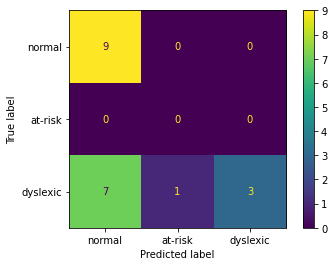

 ari: 0.023  presicion: 0.803  recall:0.600  f1-score: 0.560  auc roc:  0.682  tnr:  0.771 


In [56]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "at-risk", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, ])


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [ ]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))




In [ ]:
shap_values = explainer(x_test)



In [ ]:


print("Shap values are determined!")




In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape




In [ ]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





In [ ]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





In [ ]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




In [ ]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [ ]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


